# Credit Risk Analysis - Modular Structure

This notebook provides comprehensive analysis and visualization for credit risk prediction.

## Structure:
1. **Data Loading and Cleaning** - Using `data_cleaning.py`
2. **Exploratory Data Analysis (EDA)** - Using `eda.py`
3. **Feature Engineering** - Using `feature_engineering.py`
4. **Model Training** - Using `train.py`
5. **Model Evaluation** - Using `test.py`
6. **Visualizations** - All visualizations in this notebook


In [1]:
import os
import eda
import sys
import train
import config
import warnings
import numpy as np
import pandas as pd
import data_cleaning
import seaborn as sns
import feature_engineering
import matplotlib.pyplot as plt
import testing as test_module
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.path.abspath('')))
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Data


In [2]:
df_raw = pd.read_excel(config.DATA_PATHS['raw_data'])
print(f"Dataset Shape: {df_raw.shape}")
print(f"Number of features: {df_raw.shape[1] - 1}")
print(f"Number of records: {df_raw.shape[0]}")


print("\nFirst few rows:")
df_raw.head()


Dataset Shape: (15000, 20)
Number of features: 19
Number of records: 15000

First few rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_title,emp_length,annual_inc,delinq_2yrs,open_acc,total_acc,total_pymnt,total_pymnt_inv,last_pymnt_amnt,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default
0,1,M0000001,16795.0,16505.0,15094.0,36,32.66,Data Scientist,9 years,228362.0,0.0,6.0,12.0,1459.92,1377.66,39.12,191.0,30634.0,13996.0,0
1,2,M0000002,1860.0,1848.0,1494.0,60,2.17,Developer,7 years,273685.0,1.0,14.0,20.0,137.61,133.20,1.74,60.0,158169.0,97196.0,0
2,3,M0000003,39158.0,37619.0,34683.0,36,76.14,Manager,1 year,165933.0,0.0,11.0,17.0,2688.63,2460.36,77.56,65.0,66504.0,31634.0,0
3,4,M0000004,12284.0,12266.0,11096.0,60,14.33,Manager,9 years,136818.0,0.0,7.0,16.0,980.01,907.17,13.45,50.0,101207.0,99850.0,0
4,5,M0000005,7265.0,6953.0,6651.0,60,8.48,Analyst,2 years,114755.0,0.0,13.0,15.0,513.38,508.43,8.86,88.0,108914.0,68794.0,0


## 2. Data Prediction


In [3]:
df_cleaned, y, removed_columns = data_cleaning.clean_data(df_raw, target_column='default')
print(f"\nCleaned data shape: {df_cleaned.shape}")

DATA CLEANING

1. Removing ID columns...
   ✓ Removed 2 columns: ['id', 'member_id']

2. Converting emp_length...
   ✓ Converted emp_length to numeric using mapping

3. Applying business logic constraints...
   ✓ Business logic constraints applied

4. Handling missing values...
   ✓ Filled emp_title missing values with 'Unknown'
   ✓ Filled delinq_2yrs missing values with 0
   ✓ Filled 13 numerical columns with median: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

✓ Data cleaning complete!
  - Original features: 19
  - Remaining features: 17
  - Removed columns: 2

Cleaned data shape: (15000, 17)


### 2.1 Feature Visualizations


Visualizing 16 features...


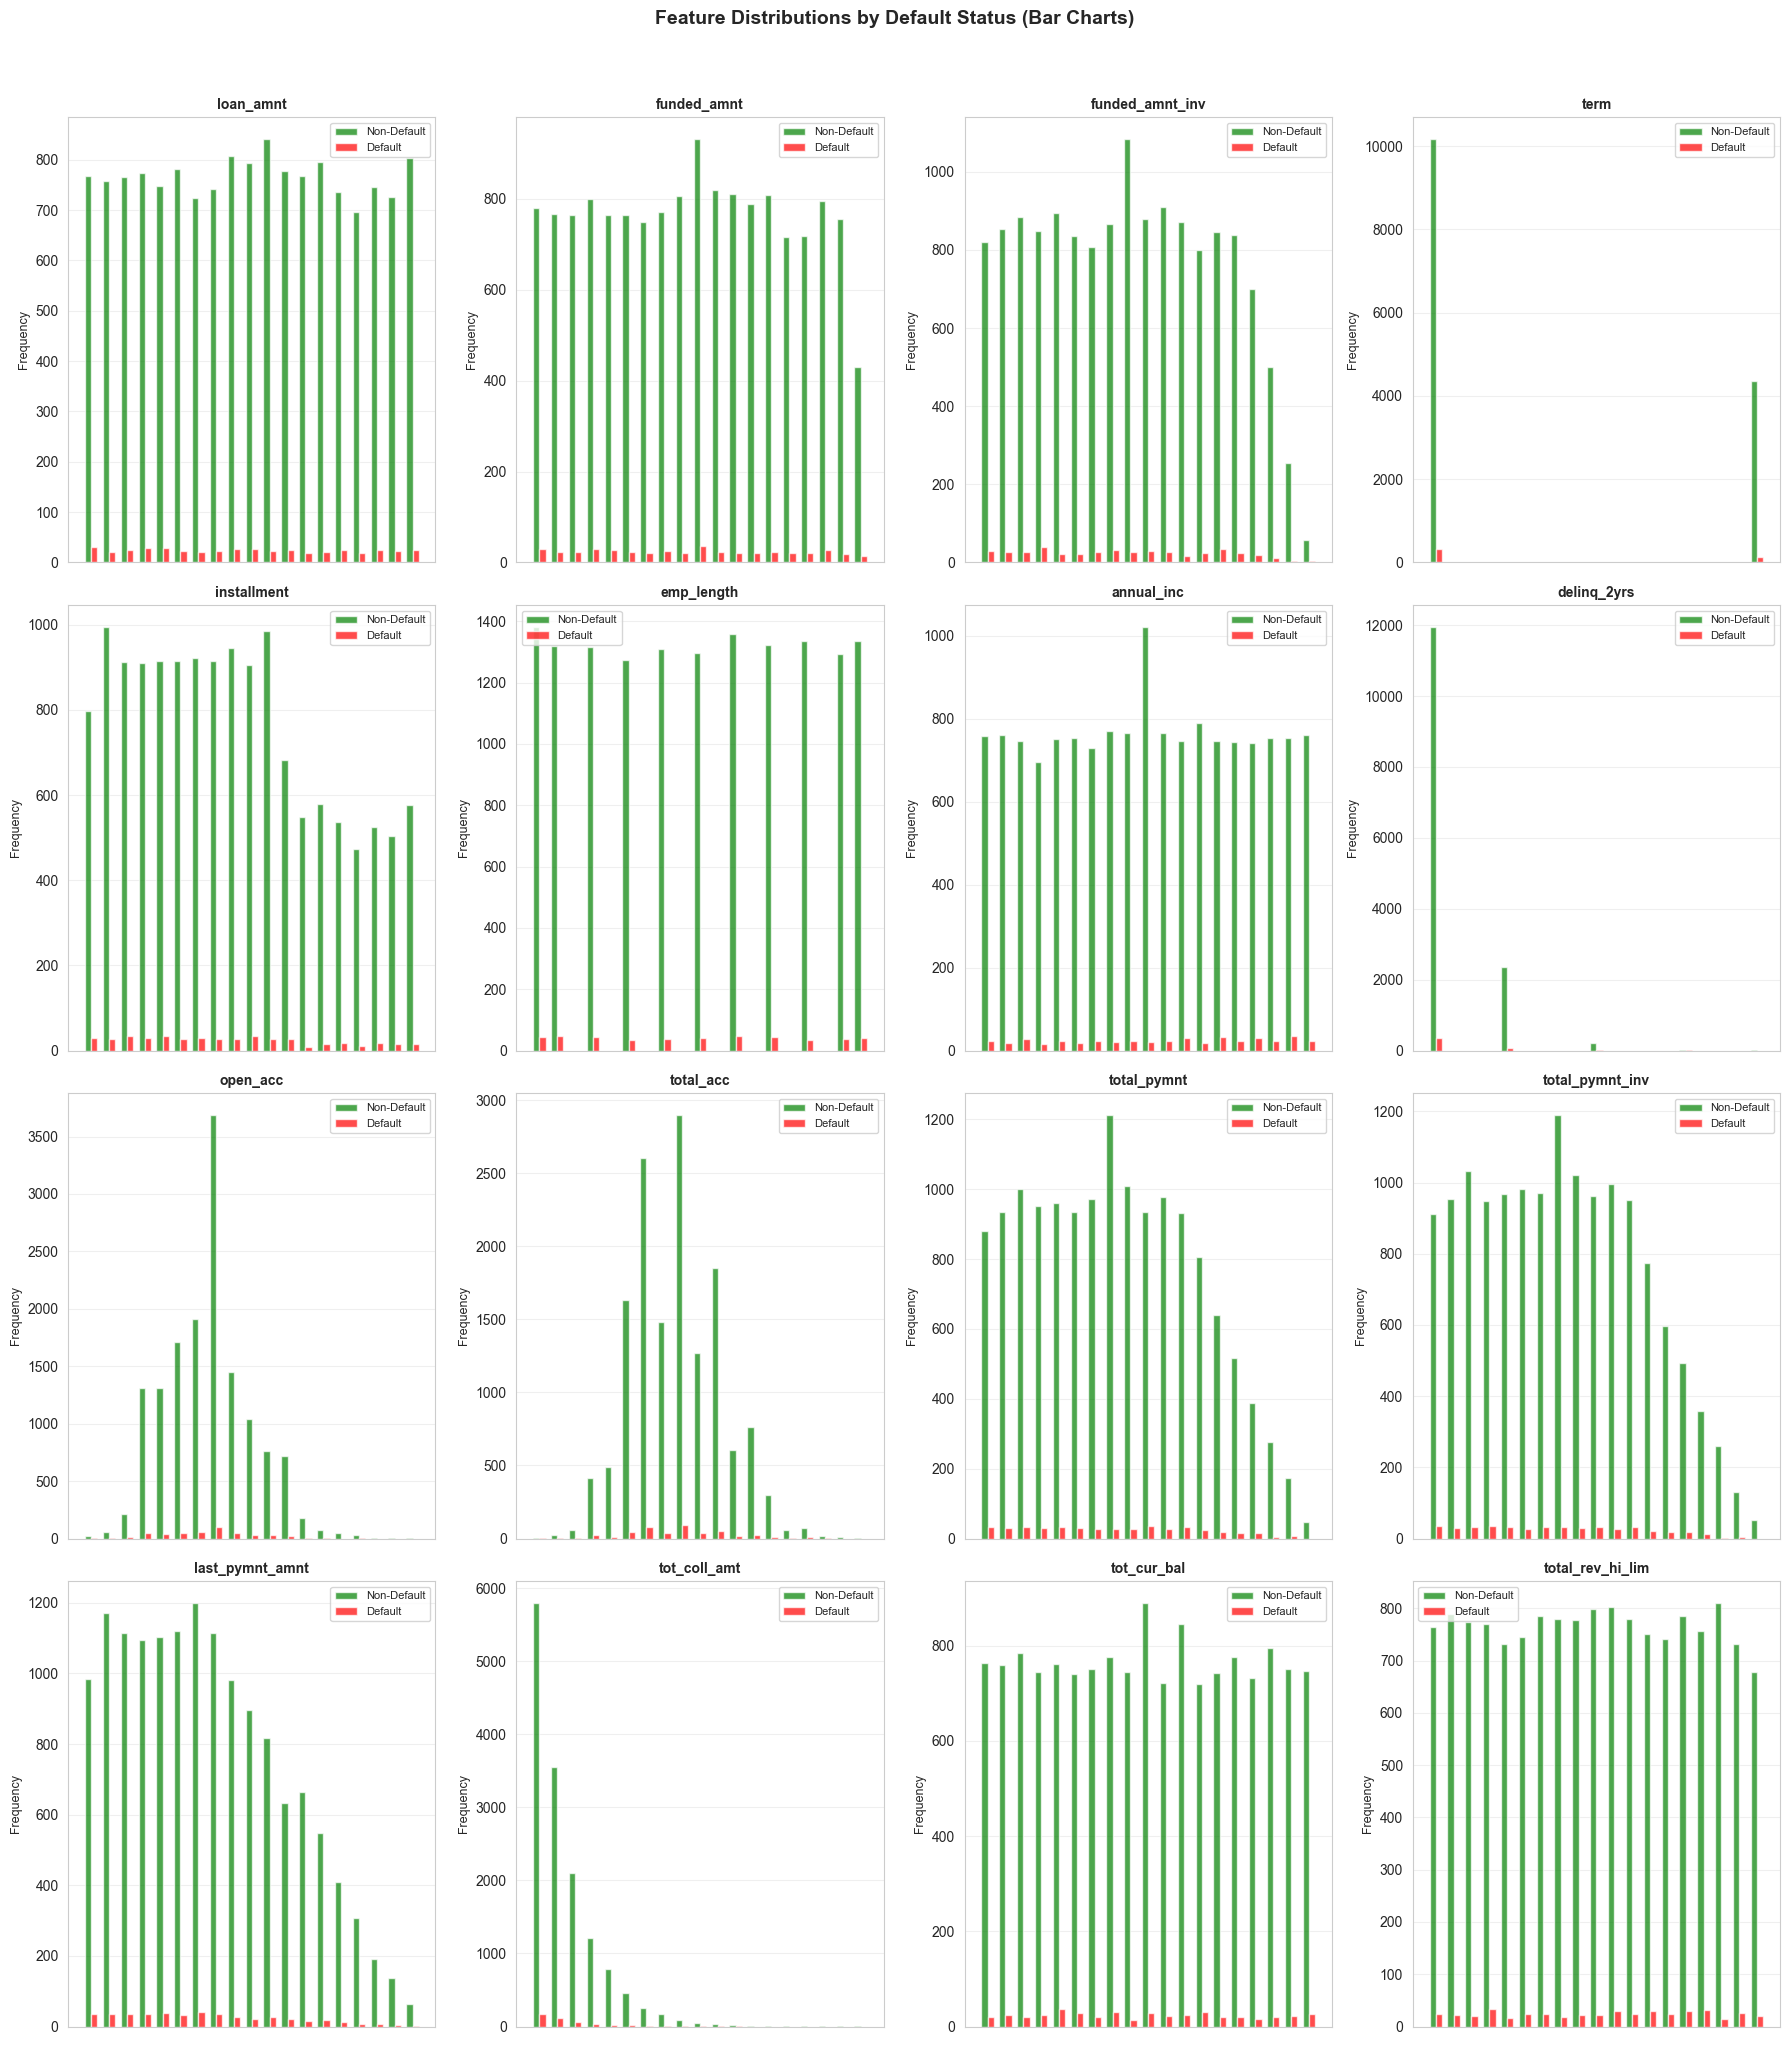

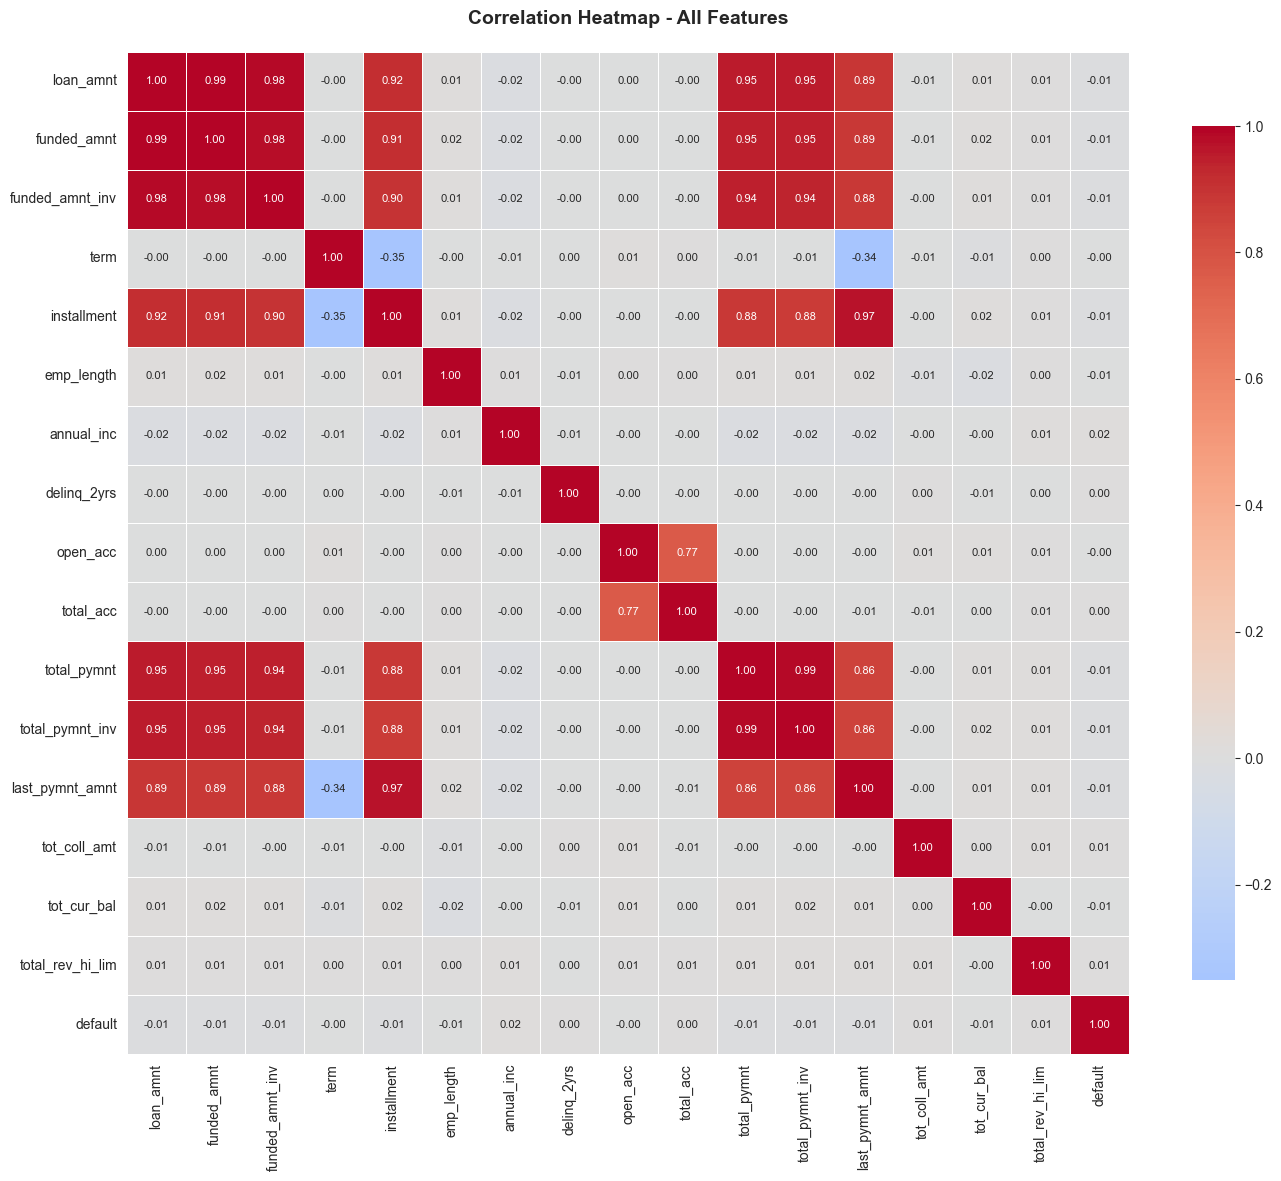


CORRELATION WITH DEFAULT (sorted by absolute value)
annual_inc          0.018248
funded_amnt        -0.010591
total_pymnt_inv    -0.009919
funded_amnt_inv    -0.009615
last_pymnt_amnt    -0.009194
installment        -0.009022
loan_amnt          -0.008708
total_pymnt        -0.007936
tot_cur_bal        -0.007183
emp_length         -0.006469
total_rev_hi_lim    0.006211
tot_coll_amt        0.005572
open_acc           -0.003703
delinq_2yrs         0.003523
total_acc           0.002991
term               -0.001655


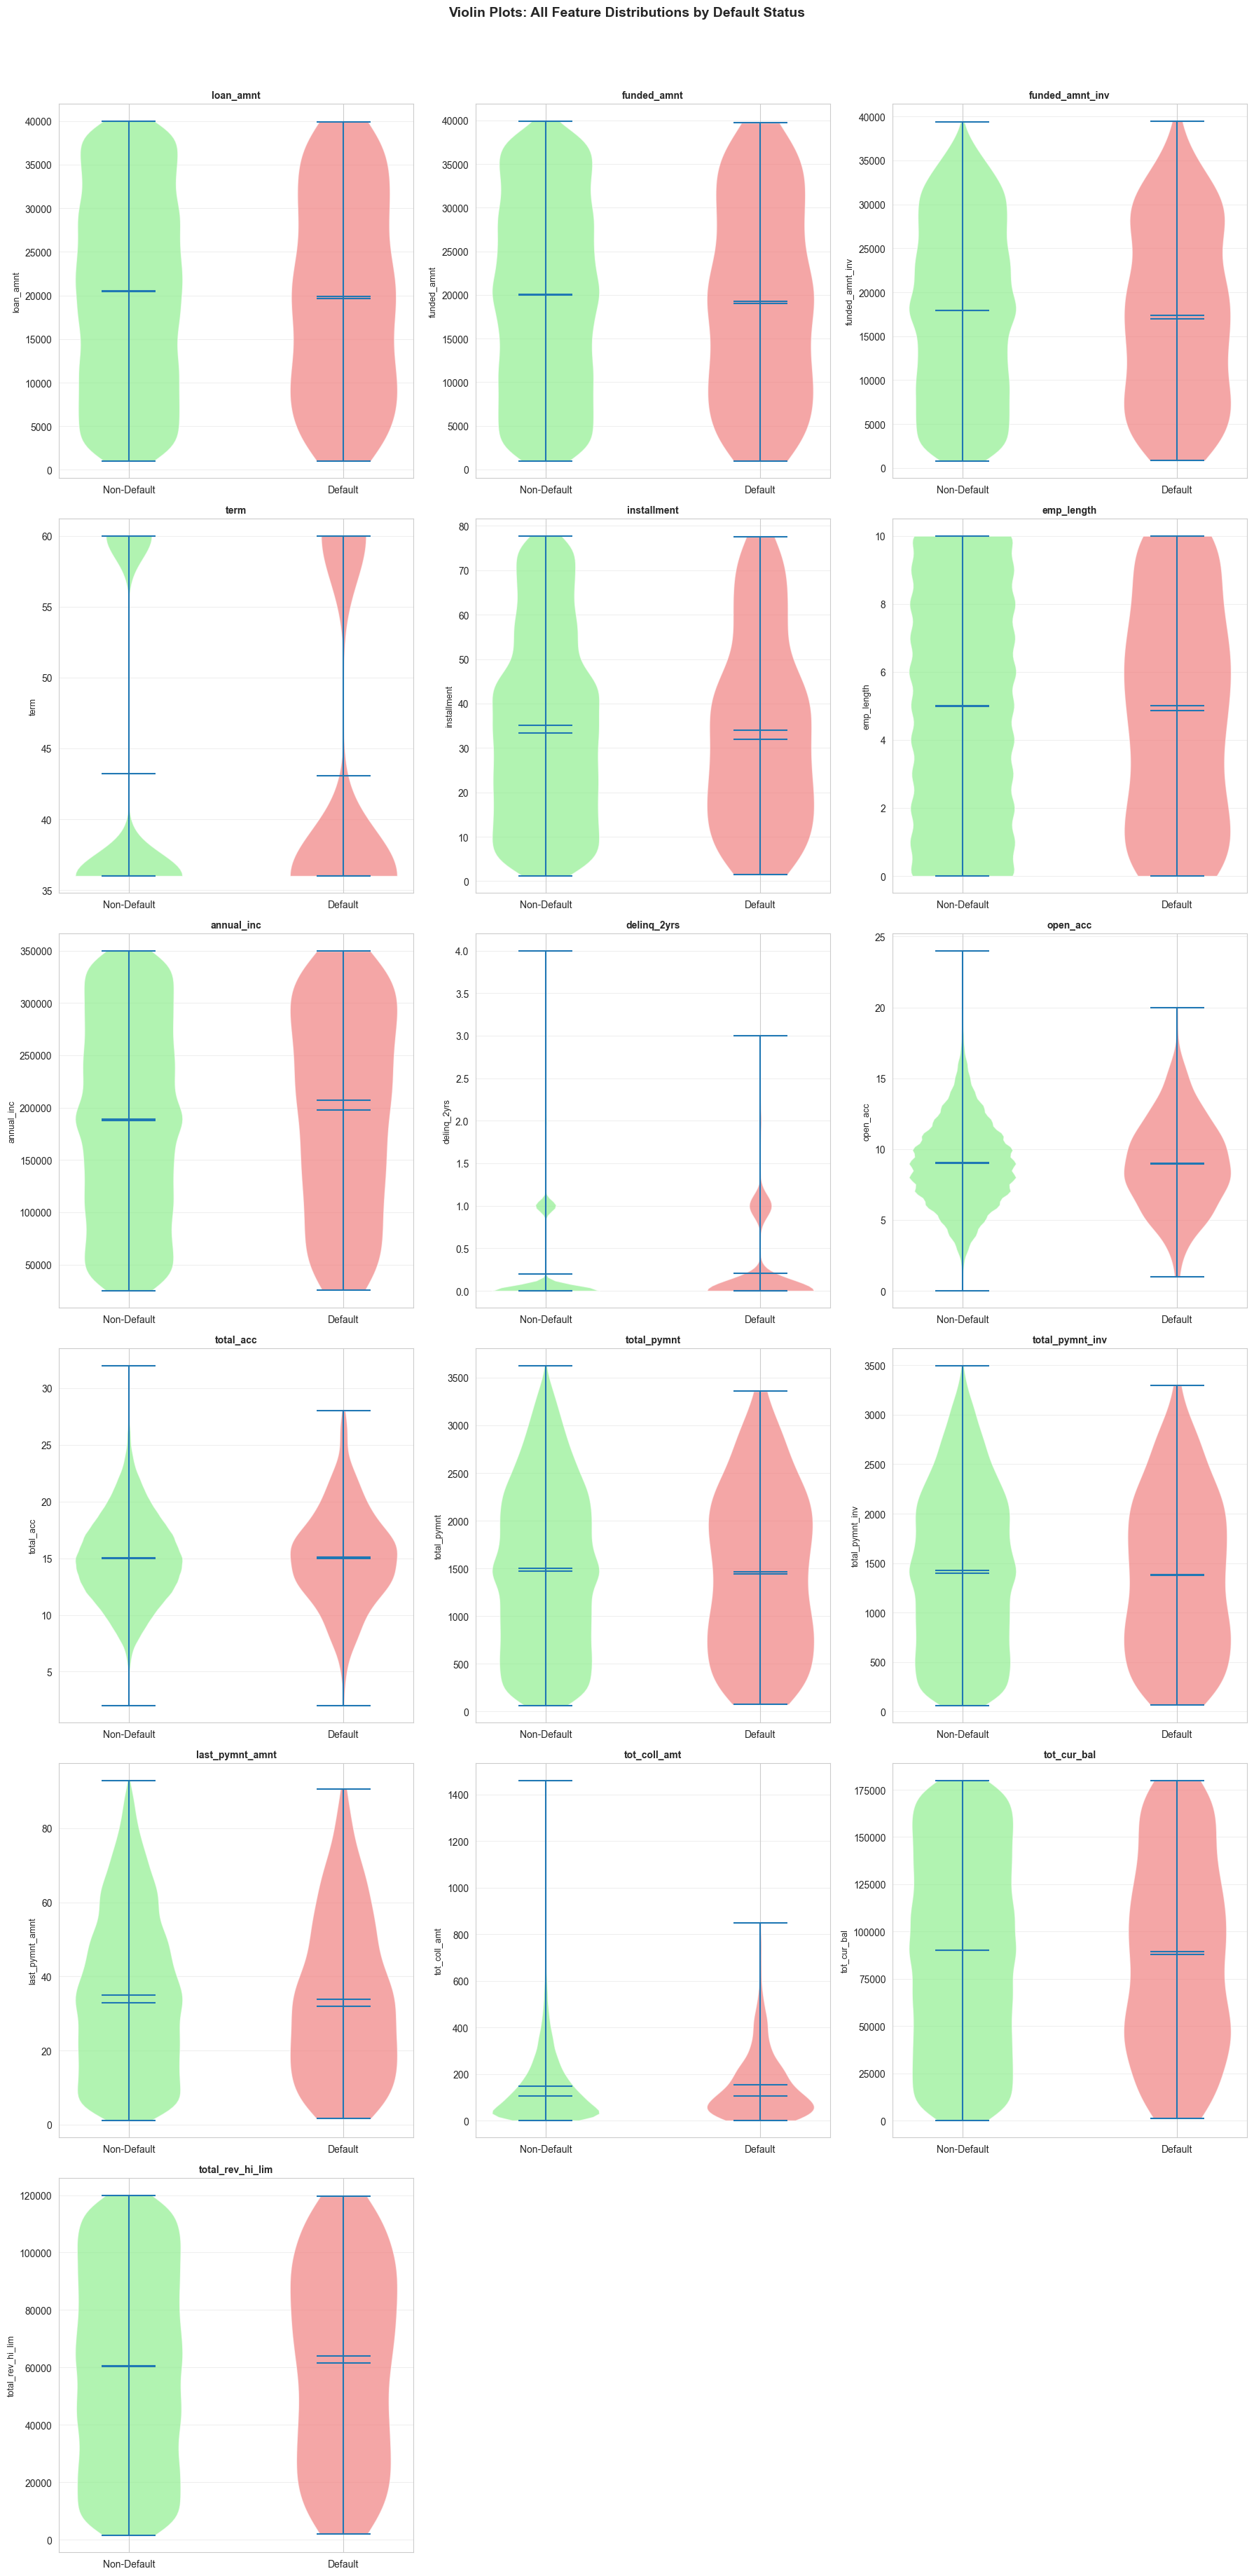


✓ Visualized 16 features with bar charts, heatmap, and violin plots


In [4]:
df_viz = df_cleaned.copy()
df_viz['default'] = y.values

eda.create_all_feature_visualizations(
    df_viz, 
    target_column='default',
    save_path=config.OUTPUT_PATHS['plots']
)


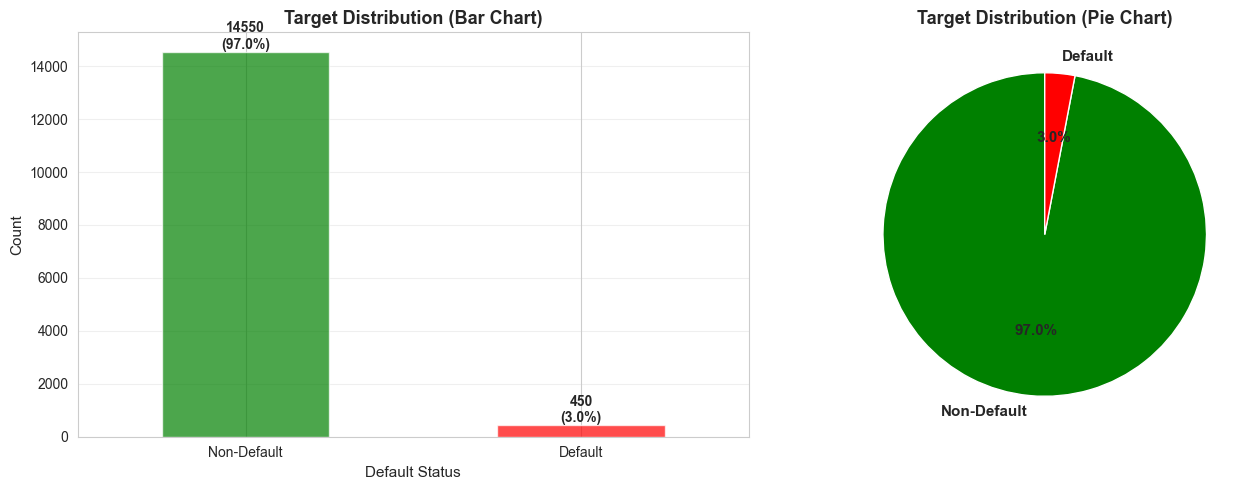

In [5]:
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

target_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Target Distribution (Bar Chart)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Default Status', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(['Non-Default', 'Default'], rotation=0)
axes[0].grid(alpha=0.3, axis='y')

for i, (idx, val) in enumerate(target_counts.items()):
    axes[0].text(i, val, f'{val}\n({target_percentages[idx]:.1f}%)', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

colors = ['green', 'red']
axes[1].pie(target_counts.values, labels=['Non-Default', 'Default'], 
            autopct='%1.1f%%', colors=colors, startangle=90,
            textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Target Distribution (Pie Chart)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Feature Engineering



### ENGINEERED FEATURE DESCRIPTIONS
#### DTI (Debt-to-Income Ratio)
- **Description**: Measures the percentage of monthly income required to cover the new loan’s payment, indicating affordability and financial stress.
- **Formula**: installment / (annual_inc / 12)

#### Credit_Utilization (Credit Utilization Ratio)
- **Description**: Ratio of total outstanding balance to total revolvable credit limit. High values (e.g., >70%) signal financial distress.
- **Formula**: tot_cur_bal / total_rev_hi_lim

#### Payment_to_Income_Ratio
- **Description**: Isolates the new loan’s monthly payment as a fraction of monthly income to assess specific loan burden.
- **Formula**: installment / (annual_inc / 12)

#### Average_Credit_Line_Size
- **Description**: Average revolving credit limit per open account; proxy for how much trust lenders extend to the borrower.
- **Formula**: total_rev_hi_lim / open_acc

#### LTI (Loan-to-Income Ratio)
- **Description**: Total loan amount relative to annual income; captures overall leverage scale.
- **Formula**: loan_amnt / annual_inc

#### partial_payment
- **Description**: Binary flag indicating whether the last payment was below the scheduled installment; strong signal of immediate distress.
- **Formula**: 1 if last_pymnt_amnt < installment else 0

#### net_worth_estimate
- **Description**: Hypothetical — borrower’s assets minus liabilities. Not present in dataset but highly predictive.
- **Formula**: Requires external sources

#### high_income
- **Description**: Binary indicator for borrowers above a threshold (e.g., top 10% or fixed level such as $250k).
- **Formula**: 1 if annual_inc > THRESHOLD else 0

### income_squared
- **Description**: Polynomial transformation capturing non-linear income effects on risk.
- **Formula**: annual_inc ** 2

#### annual_inc
- **Description**: Raw self-reported gross annual income field.
- **Formula**: annual_inc

#### monthly_inc (income_per_month)
- **Description**: Converts annual income to monthly for cash-flow based ratios.
- **Formula**: annual_inc / 12



### 4.1 Select Features for Training


In [6]:
selected_features_to_create = [
    'partial_payment',
    'net_worth_estimate',
    'high_income',
    'income_squared',
    'annual_inc',
    'income_per_month',
    'monthly_inc'
]
# alternatively features;
# DTI',
# 'Credit_Utilization',
# 'Payment_to_Income_Ratio',
# 'Average_Credit_Line_Size',
# 'lti

# or you can use all features + selected_features_to_create;

df_engineered = feature_engineering.create_engineered_features(
    df_cleaned.copy(), 
    selected_features=selected_features_to_create
)

print(f"\nFinal dataset shape: {df_engineered.shape}")
print(f"Original features: {df_cleaned.shape[1]}")
print(f"Engineered features added: {len(selected_features_to_create)}")
print(f"Total features: {df_engineered.shape[1]}")

# Only use the features explicitly listed in selected_features_to_create for selection
selected_features = selected_features_to_create.copy()

df_engineered = df_engineered[selected_features].copy()
df_engineered['default'] = y.values
print(df_engineered.shape)
print(f"\nSelected {len(selected_features)} features for visualization:")
print(f"Selected features: {selected_features}")
print(f"\nVisualization dataset shape: {df_engineered.shape}")

FEATURE ENGINEERING
Creating only 7 selected features: ['partial_payment', 'net_worth_estimate', 'high_income', 'income_squared', 'annual_inc', 'income_per_month', 'monthly_inc']
   ✓ Created 'partial_payment': Partial payment ratio
   ✓ Created 'income_squared': Income squared
   ✓ Created 'income_per_month': Monthly income
   ✓ Created 'net_worth_estimate': Net worth estimate
   ✓ Created 'high_income': High income indicator
   ✓ Created 'monthly_inc': Monthly income

✓ Feature engineering complete!
  - Original features: 17
  - Engineered features created: 6
  - Total features: 23

Final dataset shape: (15000, 23)
Original features: 17
Engineered features added: 7
Total features: 23
(15000, 8)

Selected 7 features for visualization:
Selected features: ['partial_payment', 'net_worth_estimate', 'high_income', 'income_squared', 'annual_inc', 'income_per_month', 'monthly_inc']

Visualization dataset shape: (15000, 8)


In [7]:
df_engineered.head()


,partial_payment,net_worth_estimate,high_income,income_squared,annual_inc,income_per_month,monthly_inc,default
0,0.011372,180933.0,0,5.214920e+10,228362.0,19030.166667,19030.166667,0
1,0.032258,113656.0,1,7.490348e+10,273685.0,22807.083333,22807.083333,0
2,0.001660,60271.0,0,2.753376e+10,165933.0,13827.750000,13827.750000,0
3,0.004070,23327.0,0,1.871917e+10,136818.0,11401.500000,11401.500000,0
4,0.012113,-1424.0,0,1.316871e+10,114755.0,9562.916667,9562.916667,0


Visualizing 7 features...


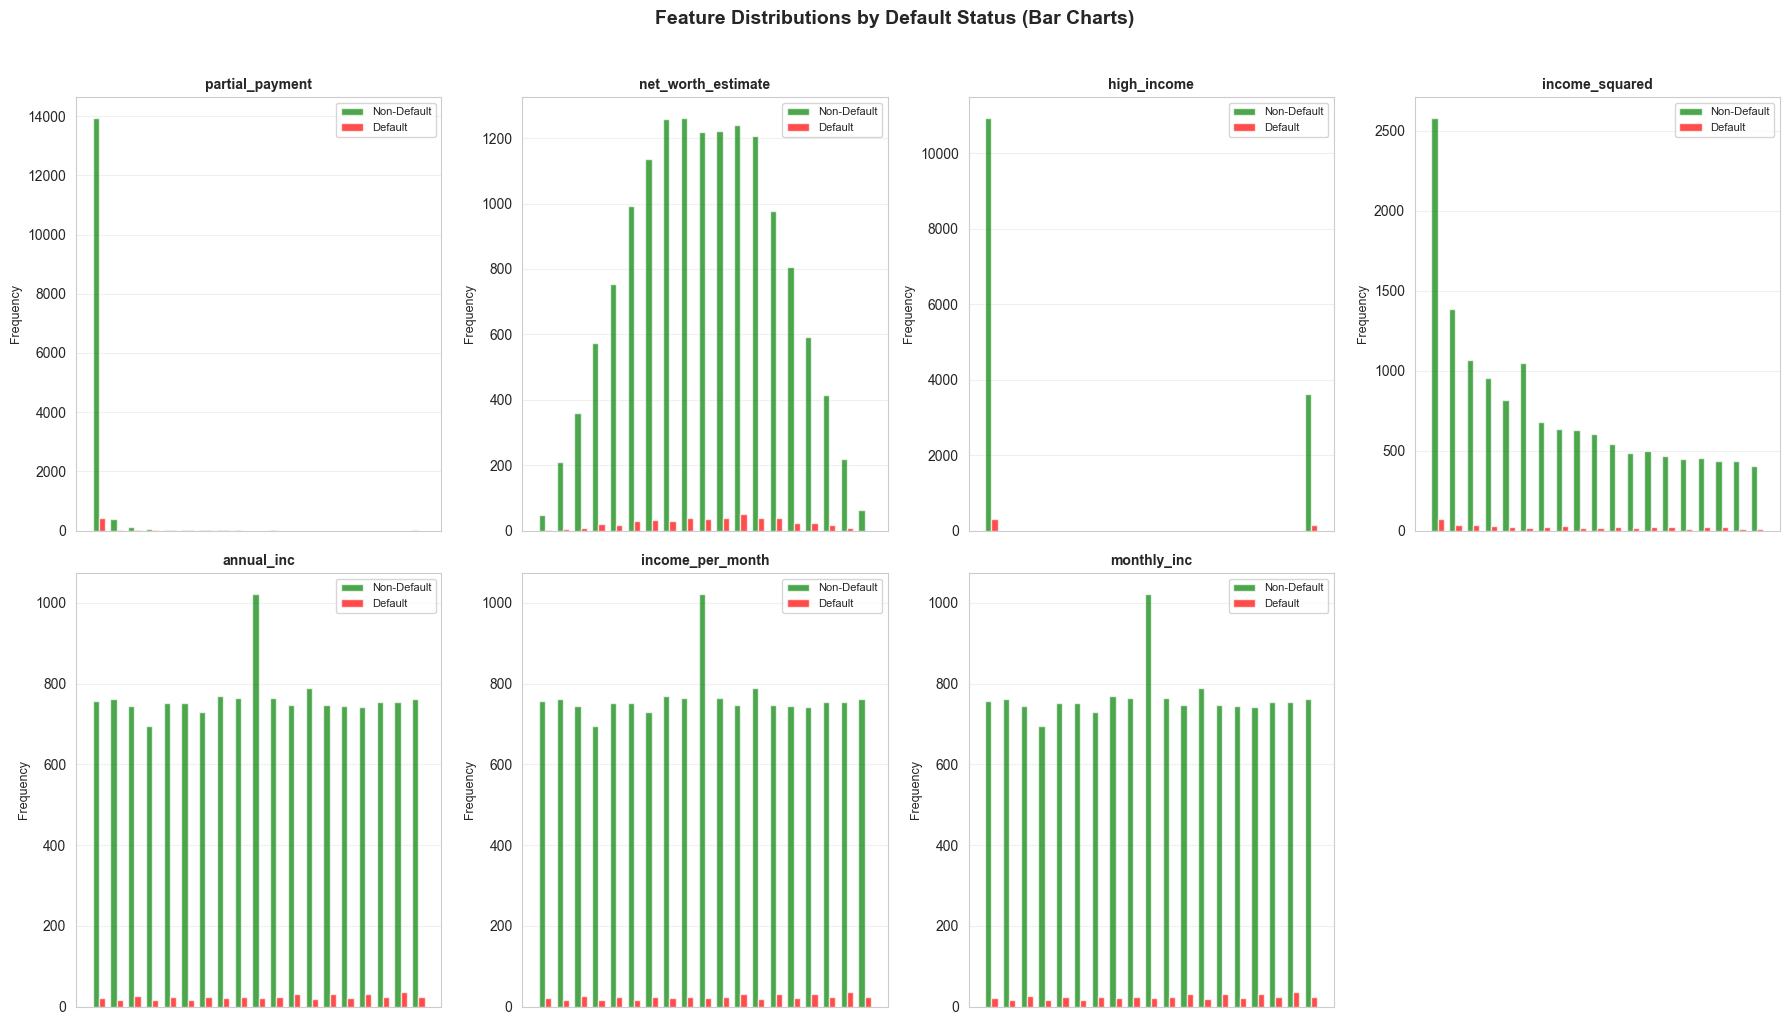

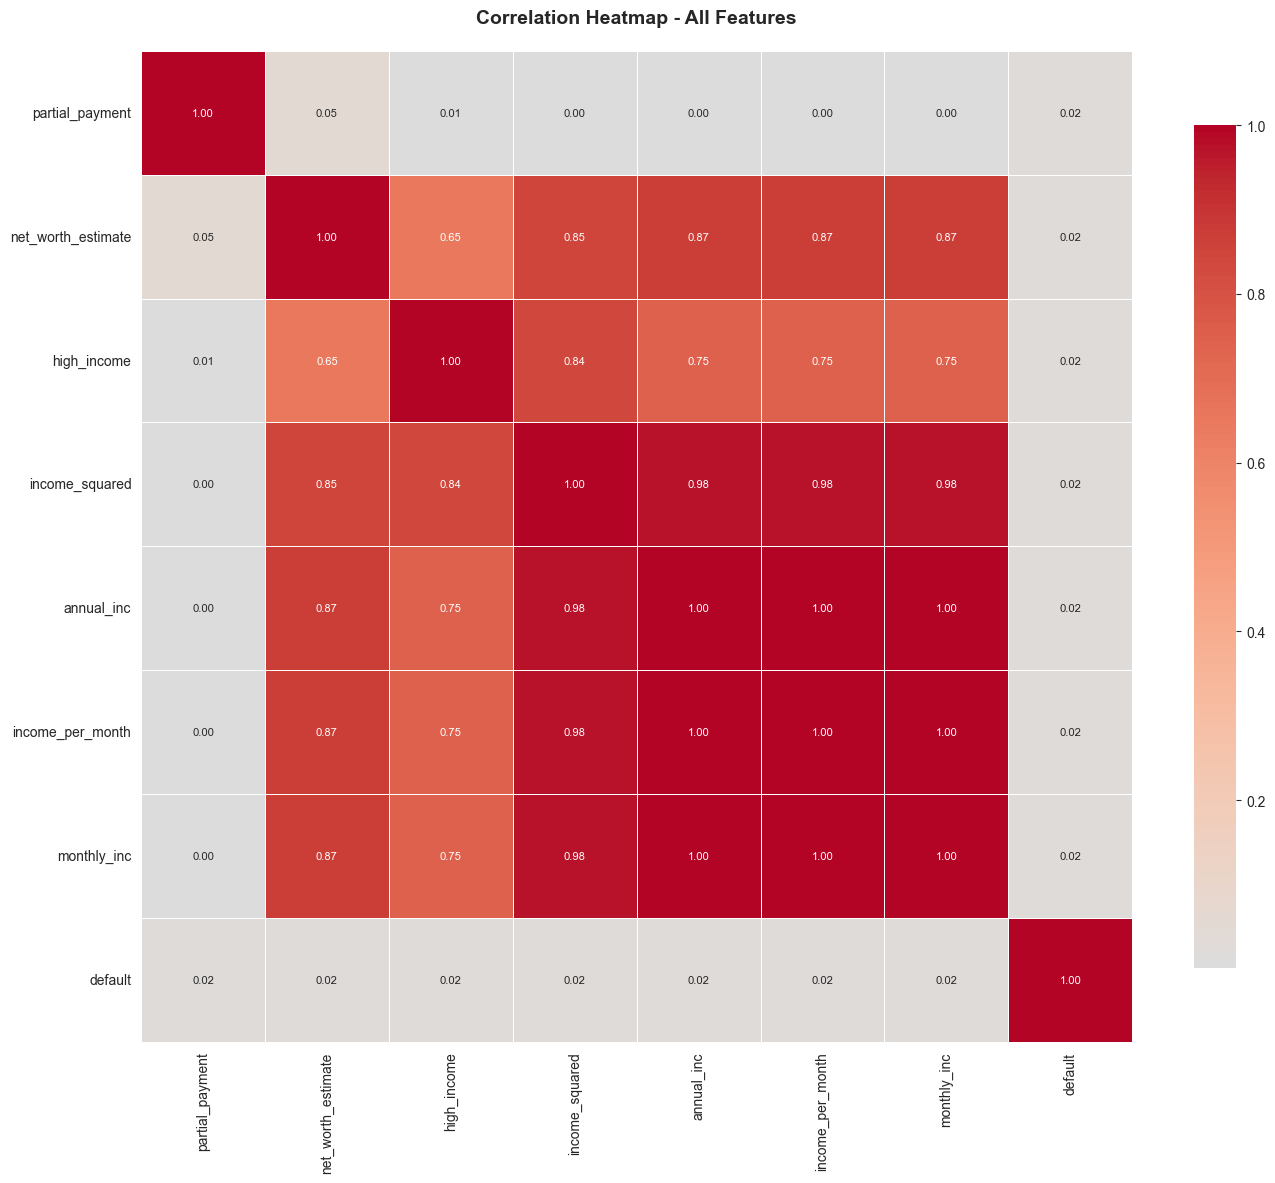


CORRELATION WITH DEFAULT (sorted by absolute value)
partial_payment       0.024007
net_worth_estimate    0.020192
high_income           0.019404
income_squared        0.019337
annual_inc            0.018248
income_per_month      0.018248
monthly_inc           0.018248


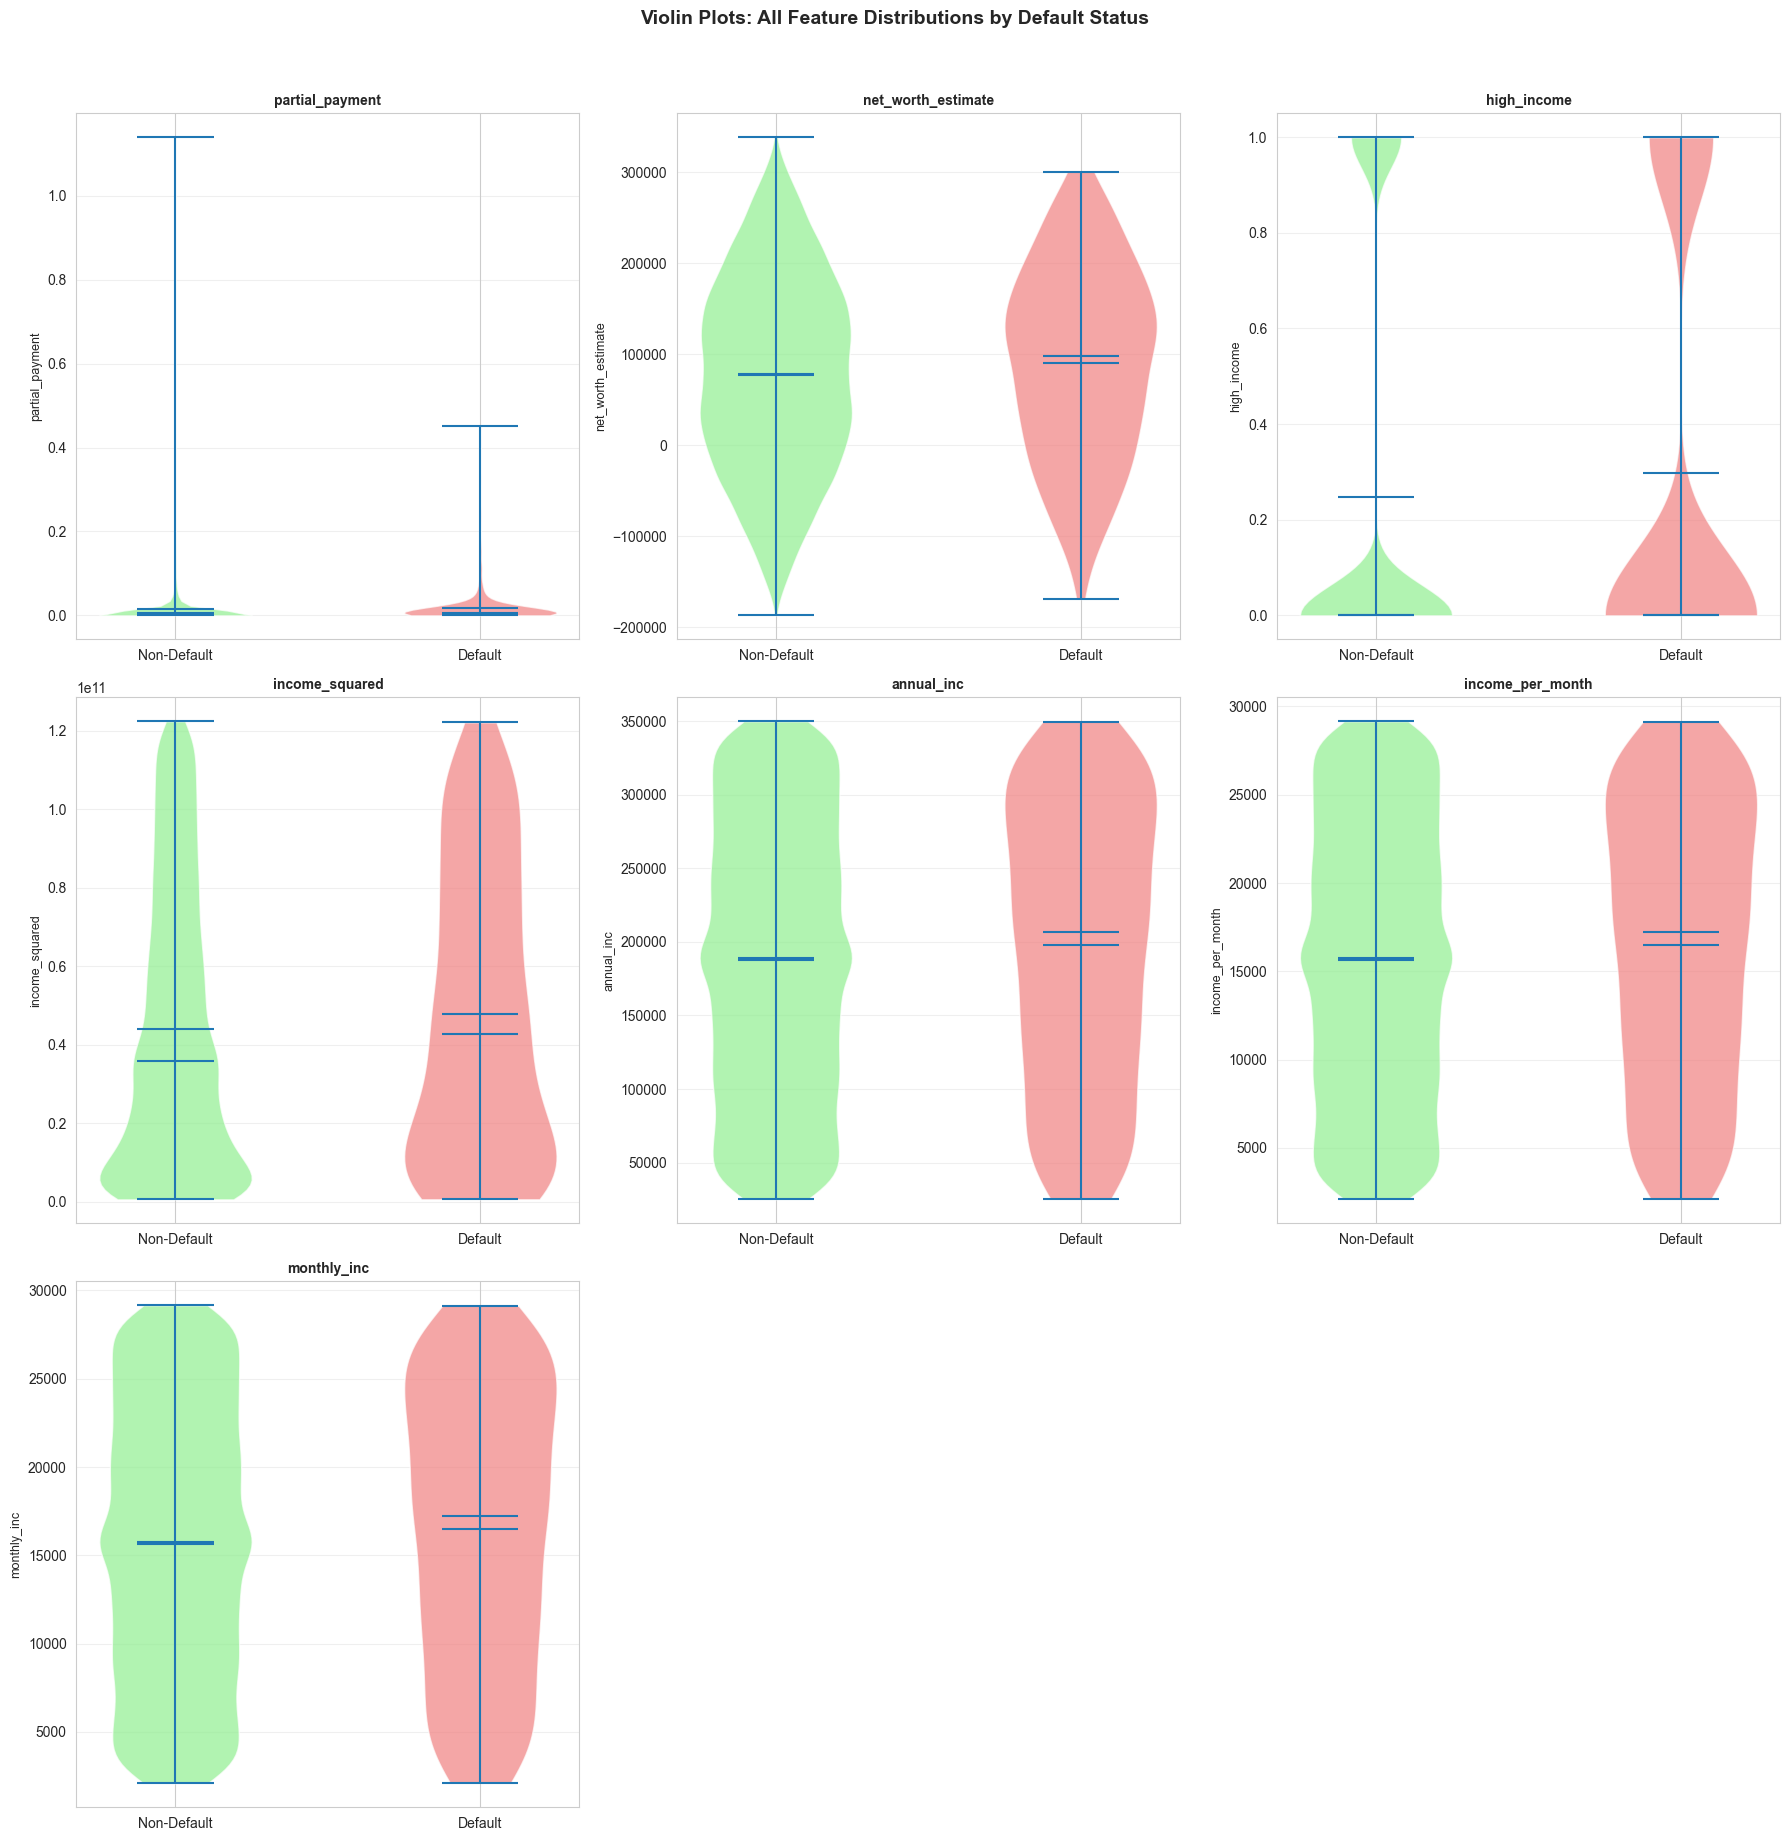


✓ Visualized 7 features with bar charts, heatmap, and violin plots


In [8]:

df_engineered['default'] = y.values

eda.create_all_feature_visualizations(
    df_engineered, 
    target_column='default',
    save_path=config.OUTPUT_PATHS['plots']
)


In [9]:
df_engineered.head()

,partial_payment,net_worth_estimate,high_income,income_squared,annual_inc,income_per_month,monthly_inc,default
0,0.011372,180933.0,0,5.214920e+10,228362.0,19030.166667,19030.166667,0
1,0.032258,113656.0,1,7.490348e+10,273685.0,22807.083333,22807.083333,0
2,0.001660,60271.0,0,2.753376e+10,165933.0,13827.750000,13827.750000,0
3,0.004070,23327.0,0,1.871917e+10,136818.0,11401.500000,11401.500000,0
4,0.012113,-1424.0,0,1.316871e+10,114755.0,9562.916667,9562.916667,0


## 5. Model Training and Evaluation

### 5.1 Train-Test Split


In [10]:
df_features = df_engineered.drop(columns=['default'])

X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    y,
    test_size=config.TRAIN_TEST_SPLIT['test_size'],
    random_state=config.TRAIN_TEST_SPLIT['random_state'],
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set target distribution:")
print(y_test.value_counts(normalize=True))
print("\nX_train columns:", X_train.columns.tolist())
X_train.head()


Training set shape: (12000, 7)
Test set shape: (3000, 7)

Training set target distribution:
default
0    0.97
1    0.03
Name: proportion, dtype: float64

Test set target distribution:
default
0    0.97
1    0.03
Name: proportion, dtype: float64

X_train columns: ['partial_payment', 'net_worth_estimate', 'high_income', 'income_squared', 'annual_inc', 'income_per_month', 'monthly_inc']


,partial_payment,net_worth_estimate,high_income,income_squared,annual_inc,income_per_month,monthly_inc
889,0.059187,214903.0,0,6.488279e+10,254721.0,21226.750000,21226.750000
10566,0.002824,185227.0,1,1.074935e+11,327862.0,27321.833333,27321.833333
14547,0.005227,69622.0,0,2.048419e+10,143123.0,11926.916667,11926.916667
1811,0.002122,-12187.0,0,7.647328e+09,87449.0,7287.416667,7287.416667
13027,0.000078,-120751.0,0,3.500261e+09,59163.0,4930.250000,4930.250000


### 5.2 Build Machine Learning Models

We will train all available models to predict default:
1. **Logistic Regression** - Linear model for baseline (with GridSearchCV)
2. **HistGradientBoosting** - Gradient boosting model (with GridSearchCV)
3. **KNN** - K-Nearest Neighbors (with GridSearchCV)
4. **Random Forest** - Tree-based ensemble model (with GridSearchCV)
5. **XGBoost** - Gradient boosting model (with GridSearchCV)


In [11]:

models_with_gridsearch = [
    'logistic_regression',
    'hist_gradient_boosting',
    'knn',
    'random_forest',
    'xgboost'
]

trained_models = {}
training_infos = {}

for model_name in models_with_gridsearch:
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()} with GridSearchCV...")
    print(f"{'='*80}\n")
    
    # Train model
    model, training_info = train.train_model(
        model_name=model_name,
        X_train=X_train,
        y_train=y_train,
        config_module=config
    )
    
    trained_models[model_name] = model
    training_infos[model_name] = training_info
    
    print(f"\n✓ {model_name.upper()} training completed!")
    print(f"  Best CV Score (ROC-AUC): {training_info['best_cv_score']:.4f}")
    print(f"  Best Parameters: {training_info['best_params']}")

print(f"\n{'='*80}")
print(f"✓ All models trained successfully!")
print(f"{'='*80}")
print(f"\nTrained {len(trained_models)} models: {list(trained_models.keys())}")



Training LOGISTIC_REGRESSION with GridSearchCV...

TRAINING MODEL: LOGISTIC_REGRESSION
  Numeric features (7): ['annual_inc', 'high_income', 'income_squared', 'partial_payment', 'monthly_inc', 'income_per_month', 'net_worth_estimate']

Performing GridSearchCV...
Parameter grid: {'classifier__C': [0.1, 1.0, 10.0], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']}

Training model...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV score (ROC-AUC): 0.5351

✓ LOGISTIC_REGRESSION training completed!
  Best CV Score (ROC-AUC): 0.5351
  Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Training HIST_GRADIENT_BOOSTING with GridSearchCV...

TRAINING MODEL: HIST_GRADIENT_BOOSTING
  Numeric features (7): ['annual_inc', 'high_income', 'income_squared', 'partial_payment', 'monthly_inc', 'income_per

### 5.3 Save Trained Models


In [12]:
train.save_models(trained_models, config_module=config)


SAVING MODELS
✓ Saved: models/pd_logistic_pipeline.pkl
✓ Saved: models/pd_gbm_pipeline.pkl
✓ Saved: models/pd_knn_pipeline.pkl
✓ Saved: models/pd_rf_pipeline.pkl
✓ Saved: models/pd_xgb_pipeline.pkl


## 6. Cross-Validation Evaluation

Evaluate models using cross-validation to get robust performance estimates.



Evaluating LOGISTIC_REGRESSION with Cross-Validation...


Cross-Validation Results for LOGISTIC_REGRESSION:
              Model    Metric     Mean      Std      Min      Max
logistic_regression   ROC AUC 0.535133 0.019213 0.502667 0.555764
logistic_regression  ACCURACY 0.566500 0.027901 0.538750 0.618750
logistic_regression PRECISION 0.032376 0.002177 0.029297 0.035874
logistic_regression    RECALL 0.466667 0.055971 0.402778 0.555556
logistic_regression        F1 0.060530 0.004210 0.054745 0.067397
✓ Saved visualization to plots/logistic_regression_cv_results.png


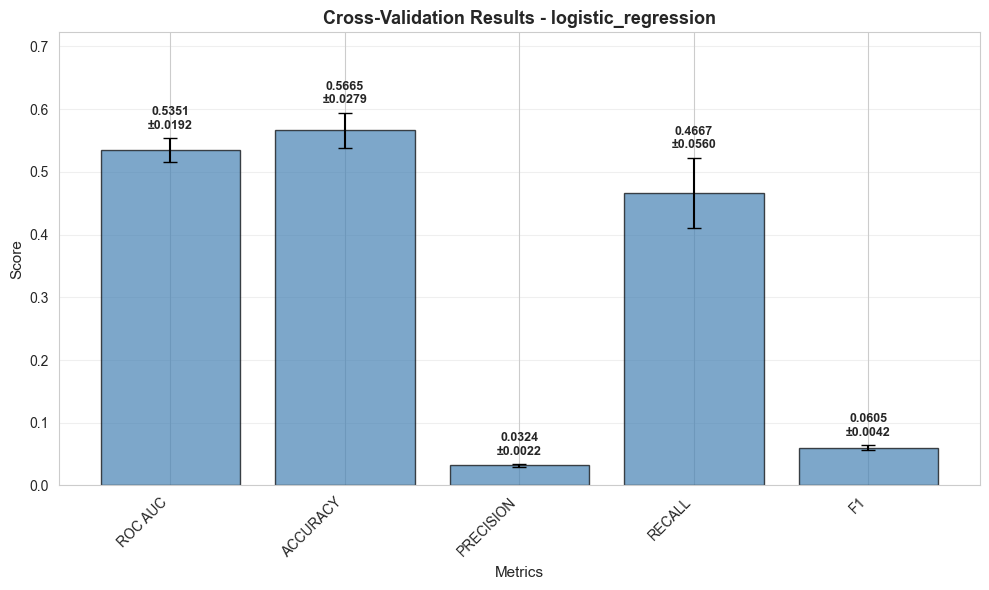


Evaluating HIST_GRADIENT_BOOSTING with Cross-Validation...


Cross-Validation Results for HIST_GRADIENT_BOOSTING:
                 Model    Metric     Mean      Std      Min      Max
hist_gradient_boosting   ROC AUC 0.522927 0.015535 0.505590 0.550079
hist_gradient_boosting  ACCURACY 0.509333 0.018483 0.479583 0.537917
hist_gradient_boosting PRECISION 0.032164 0.002035 0.029915 0.035264
hist_gradient_boosting    RECALL 0.527778 0.038289 0.486111 0.583333
hist_gradient_boosting        F1 0.060628 0.003835 0.056361 0.066508
✓ Saved visualization to plots/hist_gradient_boosting_cv_results.png


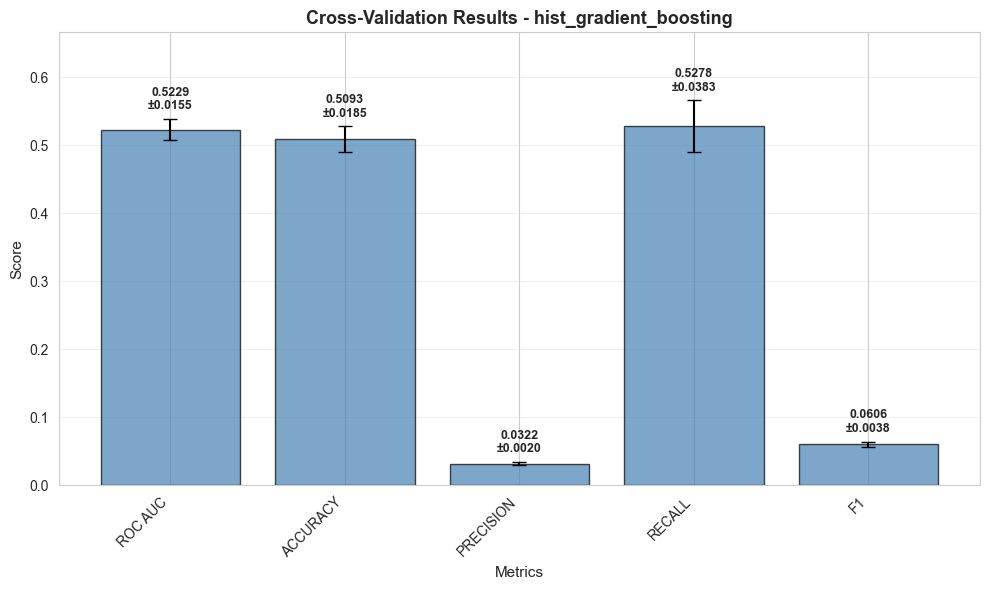


Evaluating KNN with Cross-Validation...


Cross-Validation Results for KNN:
Model    Metric     Mean      Std      Min      Max
  knn   ROC AUC 0.517720 0.045500 0.454518 0.595585
  knn  ACCURACY 0.676083 0.007330 0.663333 0.682917
  knn PRECISION 0.031010 0.007292 0.022191 0.043536
  knn    RECALL 0.325000 0.080316 0.222222 0.458333
  knn        F1 0.056614 0.013370 0.040353 0.079518
✓ Saved visualization to plots/knn_cv_results.png


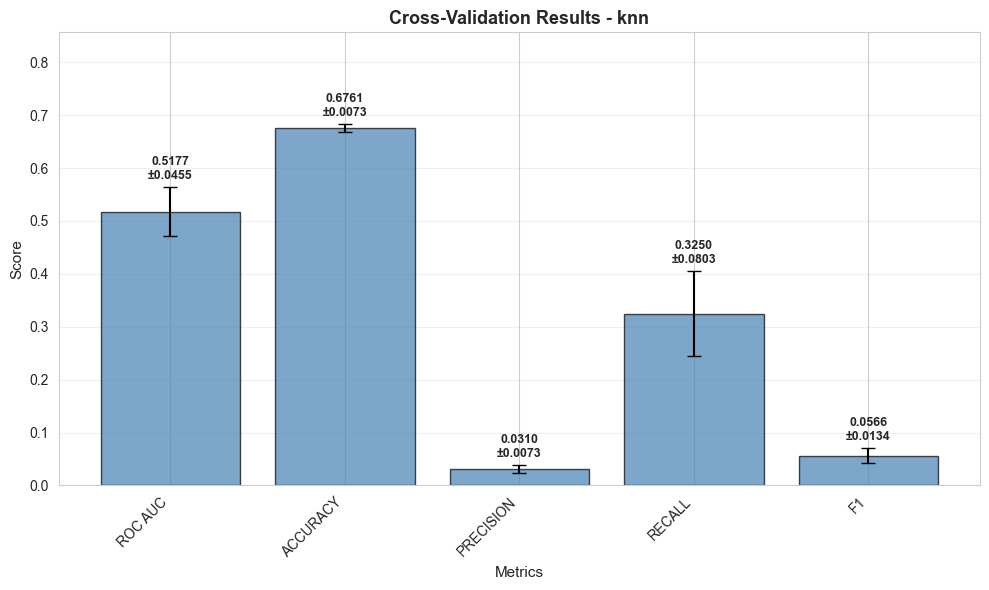


Evaluating RANDOM_FOREST with Cross-Validation...


Cross-Validation Results for RANDOM_FOREST:
        Model    Metric     Mean      Std      Min      Max
random_forest   ROC AUC 0.513648 0.028938 0.488659 0.552361
random_forest  ACCURACY 0.644250 0.025981 0.602500 0.679167
random_forest PRECISION 0.031762 0.002269 0.029343 0.034810
random_forest    RECALL 0.369444 0.050154 0.305556 0.458333
random_forest        F1 0.058466 0.004380 0.054054 0.064706
✓ Saved visualization to plots/random_forest_cv_results.png


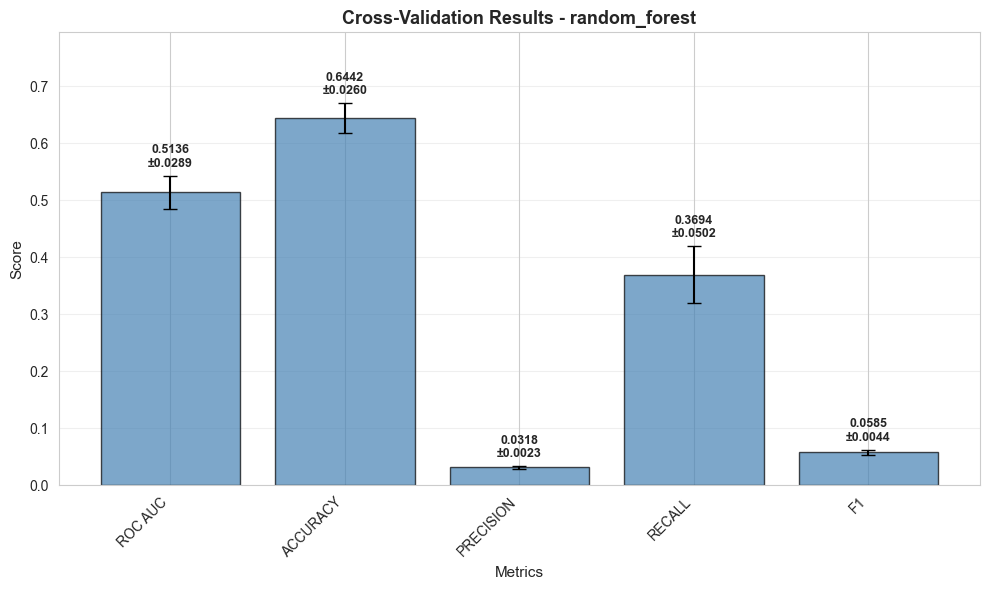


Evaluating XGBOOST with Cross-Validation...


Cross-Validation Results for XGBOOST:
  Model    Metric     Mean      Std      Min      Max
xgboost   ROC AUC 0.530039 0.021591 0.503353 0.555660
xgboost  ACCURACY 0.039333 0.005168 0.032917 0.048333
xgboost PRECISION 0.030125 0.000262 0.029807 0.030560
xgboost    RECALL 0.994444 0.006804 0.986111 1.000000
xgboost        F1 0.058479 0.000502 0.057865 0.059308
✓ Saved visualization to plots/xgboost_cv_results.png


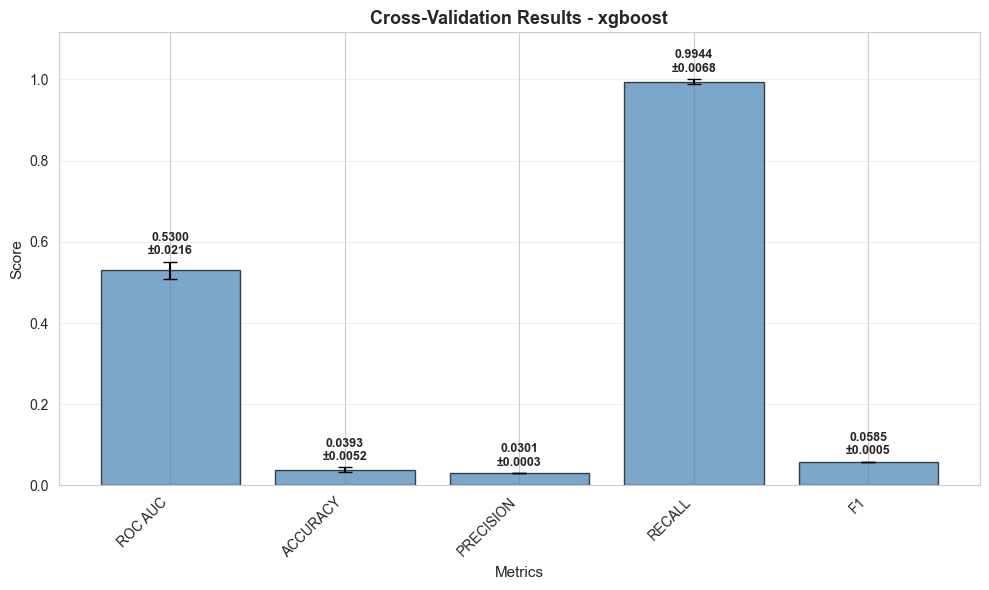


CROSS-VALIDATION SUMMARY - ALL MODELS

                 Model    Metric     Mean      Std      Min      Max
   logistic_regression   ROC AUC 0.535133 0.019213 0.502667 0.555764
   logistic_regression  ACCURACY 0.566500 0.027901 0.538750 0.618750
   logistic_regression PRECISION 0.032376 0.002177 0.029297 0.035874
   logistic_regression    RECALL 0.466667 0.055971 0.402778 0.555556
   logistic_regression        F1 0.060530 0.004210 0.054745 0.067397
hist_gradient_boosting   ROC AUC 0.522927 0.015535 0.505590 0.550079
hist_gradient_boosting  ACCURACY 0.509333 0.018483 0.479583 0.537917
hist_gradient_boosting PRECISION 0.032164 0.002035 0.029915 0.035264
hist_gradient_boosting    RECALL 0.527778 0.038289 0.486111 0.583333
hist_gradient_boosting        F1 0.060628 0.003835 0.056361 0.066508
                   knn   ROC AUC 0.517720 0.045500 0.454518 0.595585
                   knn  ACCURACY 0.676083 0.007330 0.663333 0.682917
                   knn PRECISION 0.031010 0.007292 0.022191 0.0

In [13]:

cv_results_all = {}
cv_summaries_all = []

for model_name, model in trained_models.items():
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name.upper()} with Cross-Validation...")
    print(f"{'='*80}\n")
    
    cv_results = train.evaluate_model_cv(
        model=model,
        X=X_train,
        y=y_train,
        config_module=config
    )
    
    cv_results_all[model_name] = cv_results
    

    cv_summary_df = train.summarize_cv_results(cv_results, model_name=model_name)
    cv_summaries_all.append(cv_summary_df)
    
    print(f"\nCross-Validation Results for {model_name.upper()}:")
    print(cv_summary_df.to_string(index=False))
    
    train.visualize_cv_results(
        cv_results=cv_results,
        model_name=model_name,
        save_path=config.OUTPUT_PATHS['plots']
    )

cv_summaries_combined = pd.concat(cv_summaries_all, ignore_index=True)
print(f"\n{'='*80}")
print("CROSS-VALIDATION SUMMARY - ALL MODELS")
print(f"{'='*80}\n")
print(cv_summaries_combined.to_string(index=False))


## 7. Feature Importance Analysis

Identify the most influential factors affecting default prediction.



Extracting Feature Importance for LOGISTIC_REGRESSION...

Top 10 Most Important Features for LOGISTIC_REGRESSION:
                feature  importance
num__net_worth_estimate    0.141967
   num__partial_payment    0.086580
       num__monthly_inc    0.045401
       num__high_income    0.017927
    num__income_squared    0.004922
        num__annual_inc    0.000000
  num__income_per_month    0.000000
✓ Saved visualization to plots/logistic_regression_feature_importance.png


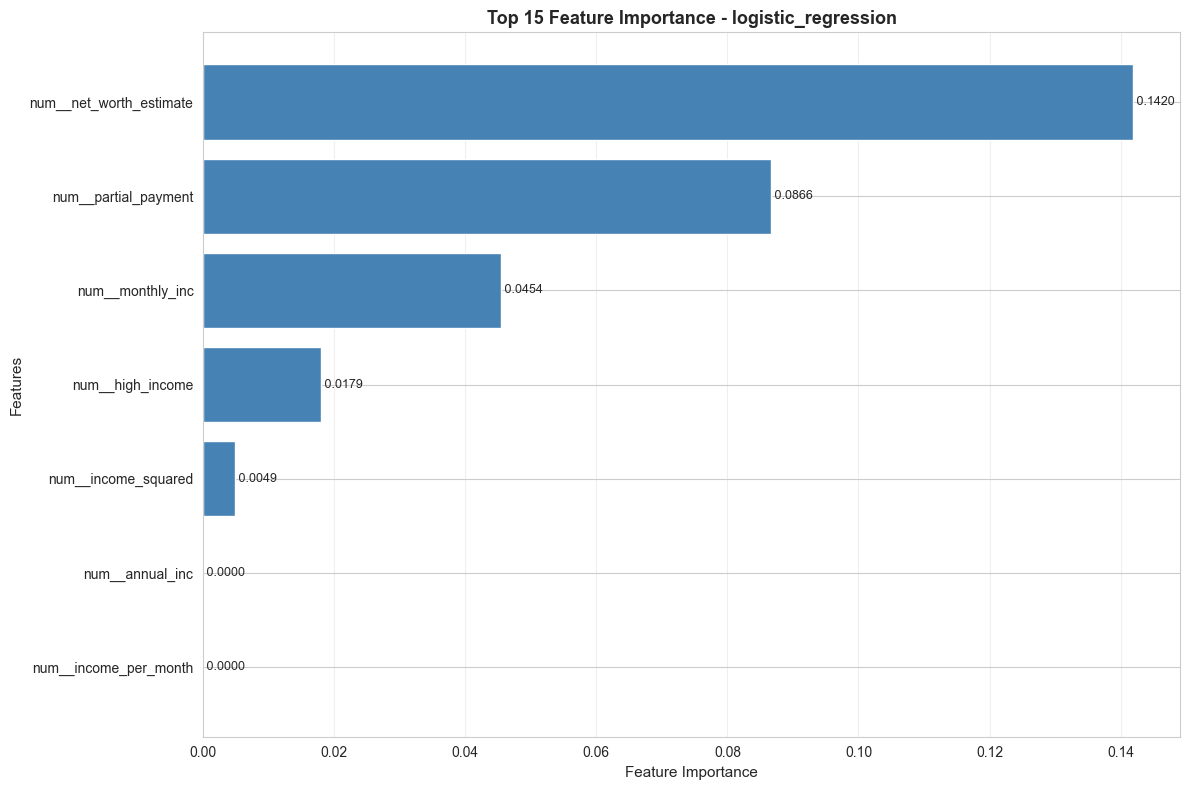


Extracting Feature Importance for HIST_GRADIENT_BOOSTING...

⚠ Warning: hist_gradient_boosting does not support native feature importance.
   Using permutation importance instead...
Top 10 Most Important Features for HIST_GRADIENT_BOOSTING:
                feature  importance
       num__monthly_inc    0.155596
        num__annual_inc    0.119674
       num__high_income    0.082318
    num__income_squared    0.000000
  num__income_per_month    0.000000
num__net_worth_estimate    0.000000
   num__partial_payment   -0.000501
✓ Saved visualization to plots/hist_gradient_boosting_feature_importance.png


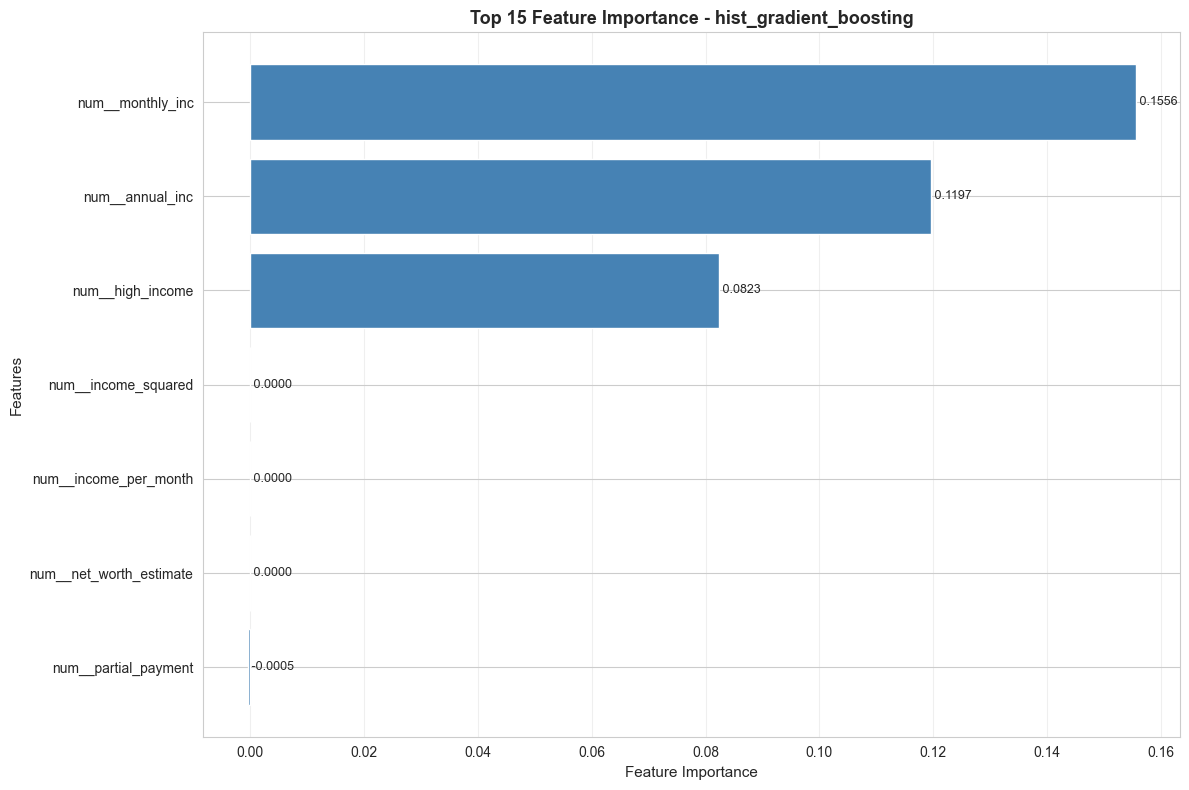


Extracting Feature Importance for KNN...

⚠ Warning: knn does not support native feature importance.
   Using permutation importance instead...
Top 10 Most Important Features for KNN:
                feature  importance
        num__annual_inc    0.373163
  num__income_per_month    0.357463
       num__monthly_inc    0.357463
num__net_worth_estimate    0.357463
       num__high_income    0.347204
   num__partial_payment    0.266045
    num__income_squared    0.139602
✓ Saved visualization to plots/knn_feature_importance.png


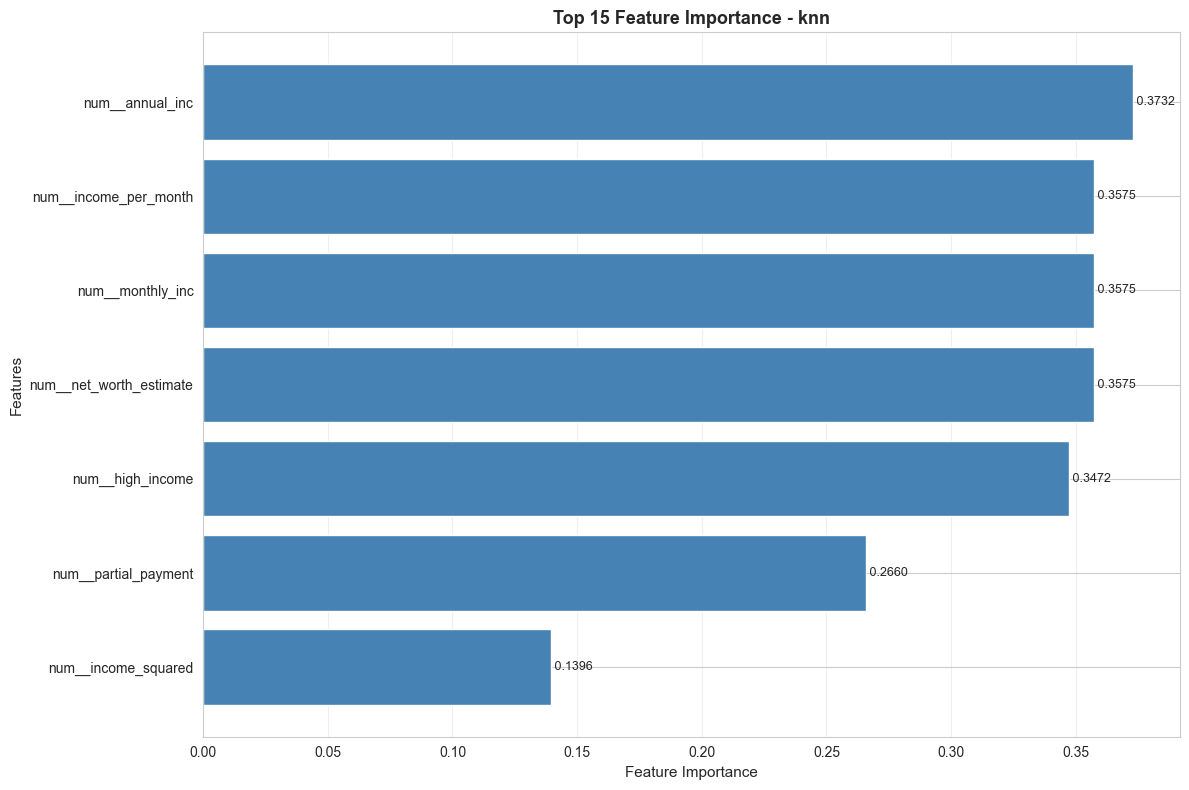


Extracting Feature Importance for RANDOM_FOREST...

Top 10 Most Important Features for RANDOM_FOREST:
                feature  importance
   num__partial_payment    0.217262
num__net_worth_estimate    0.189458
       num__monthly_inc    0.153517
    num__income_squared    0.149269
        num__annual_inc    0.147095
  num__income_per_month    0.142962
       num__high_income    0.000437
✓ Saved visualization to plots/random_forest_feature_importance.png


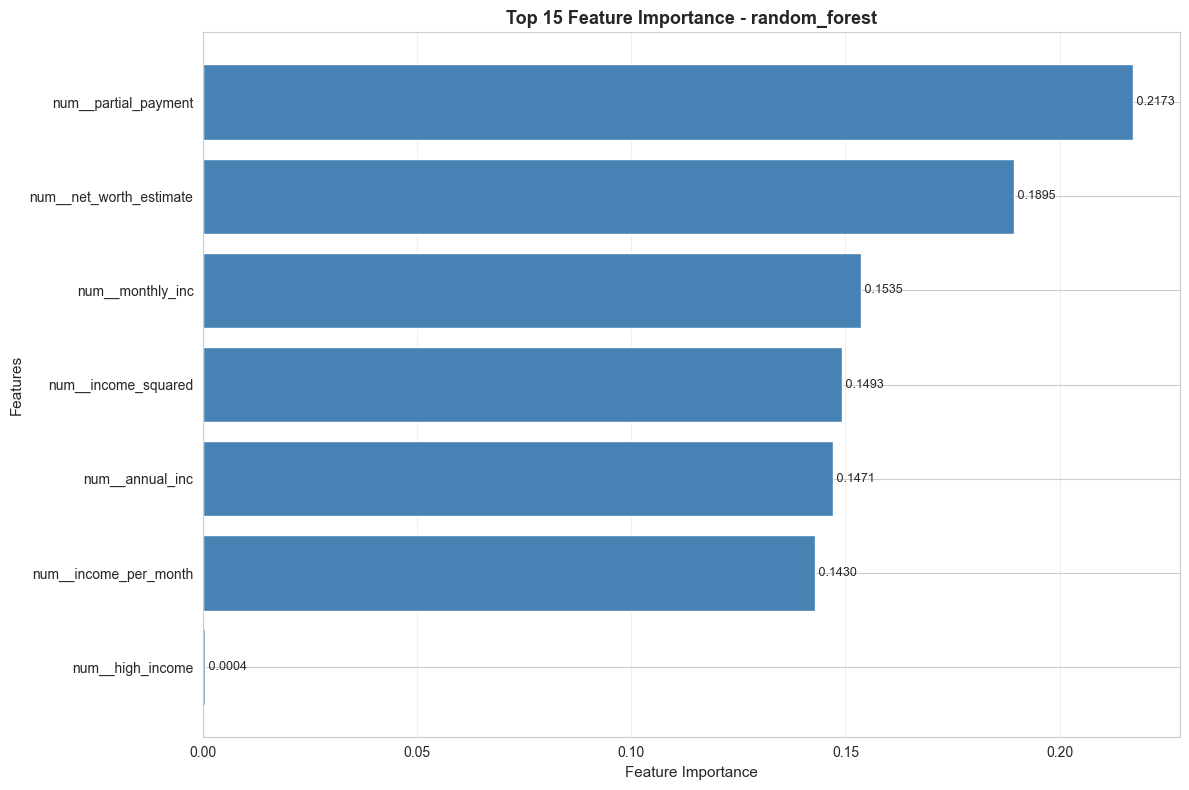


Extracting Feature Importance for XGBOOST...

Top 10 Most Important Features for XGBOOST:
                feature  importance
   num__partial_payment    0.336730
num__net_worth_estimate    0.282940
        num__annual_inc    0.200774
    num__income_squared    0.179556
       num__high_income    0.000000
       num__monthly_inc    0.000000
  num__income_per_month    0.000000
✓ Saved visualization to plots/xgboost_feature_importance.png


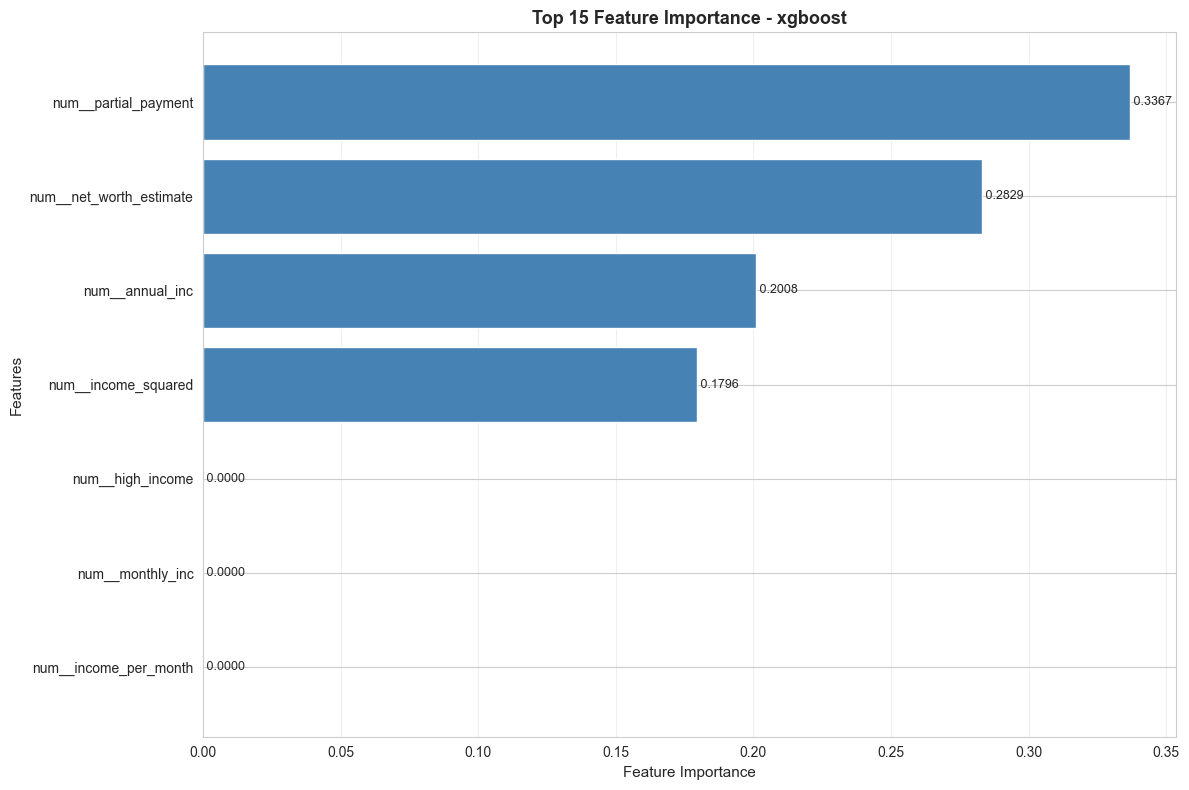

In [14]:

feature_importance_all = {}

for model_name, model in trained_models.items():
    print(f"\n{'='*80}")
    print(f"Extracting Feature Importance for {model_name.upper()}...")
    print(f"{'='*80}\n")
    
    importance_df = train.get_feature_importance(
        model=model,
        X_train=X_train,
        y_train=y_train,
        model_name=model_name
    )
    
    feature_importance_all[model_name] = importance_df
    
    print(f"Top 10 Most Important Features for {model_name.upper()}:")
    print(importance_df.head(10).to_string(index=False))
    
    train.visualize_feature_importance(
        importance_df=importance_df,
        model_name=model_name,
        top_n=15,
        save_path=config.OUTPUT_PATHS['plots']
    )


## 8. Model Results Visualization

Visualize model performance on test set including ROC curves and confusion matrices.



Visualizing Results for LOGISTIC_REGRESSION...

✓ Saved visualization to plots/logistic_regression_results.png


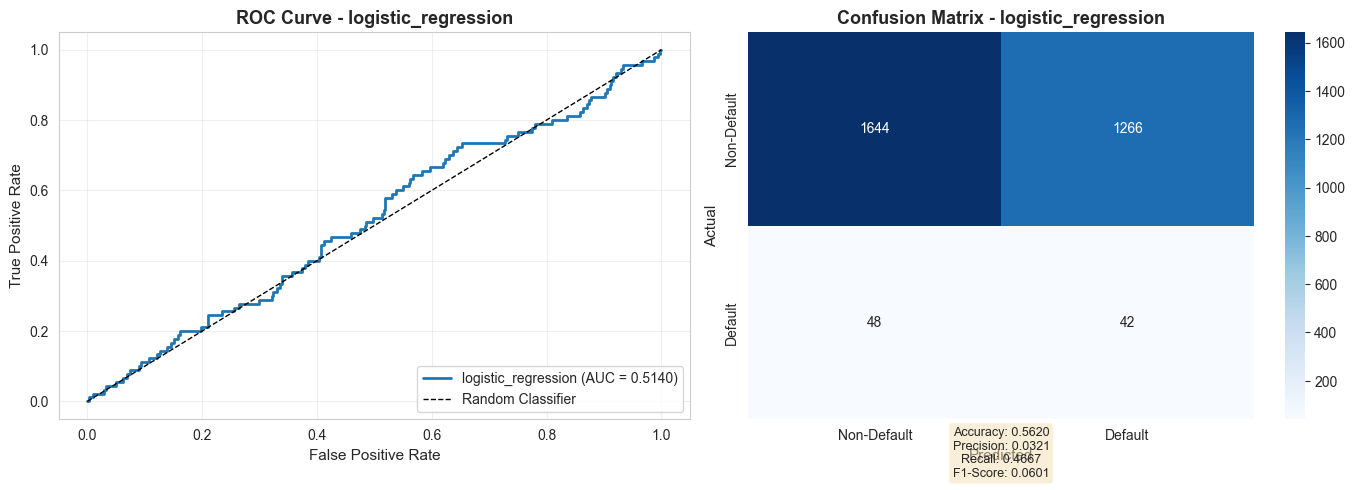


Visualizing Results for HIST_GRADIENT_BOOSTING...

✓ Saved visualization to plots/hist_gradient_boosting_results.png


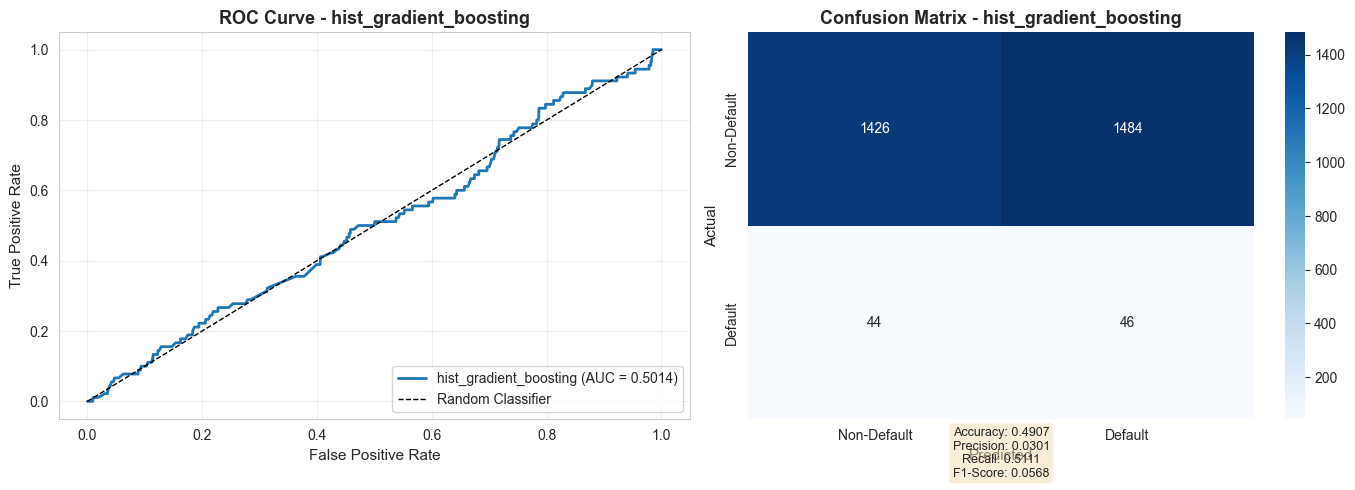


Visualizing Results for KNN...

✓ Saved visualization to plots/knn_results.png


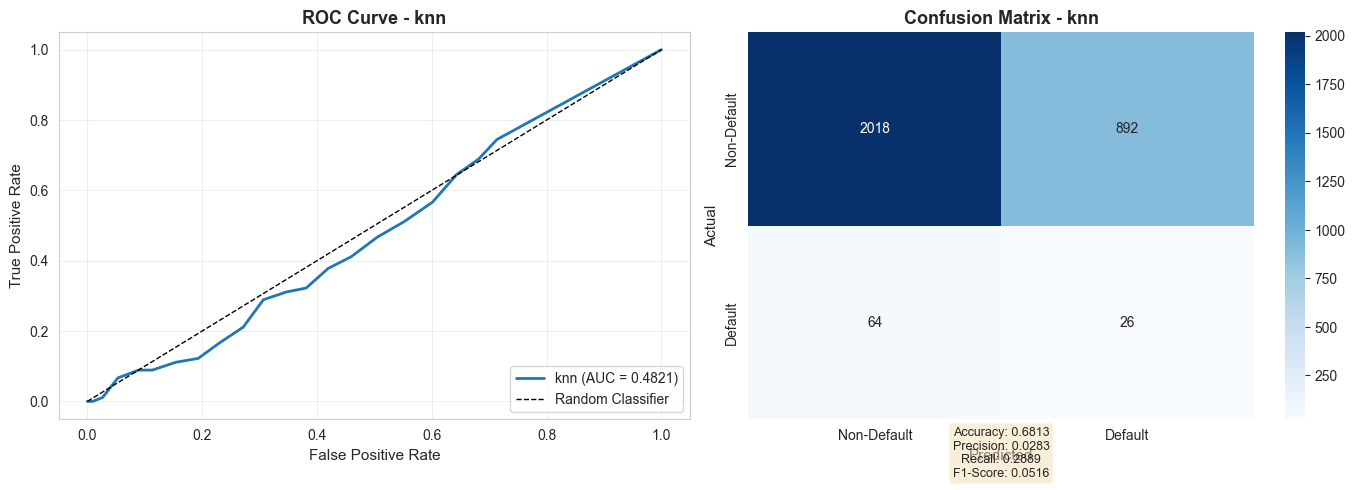


Visualizing Results for RANDOM_FOREST...

✓ Saved visualization to plots/random_forest_results.png


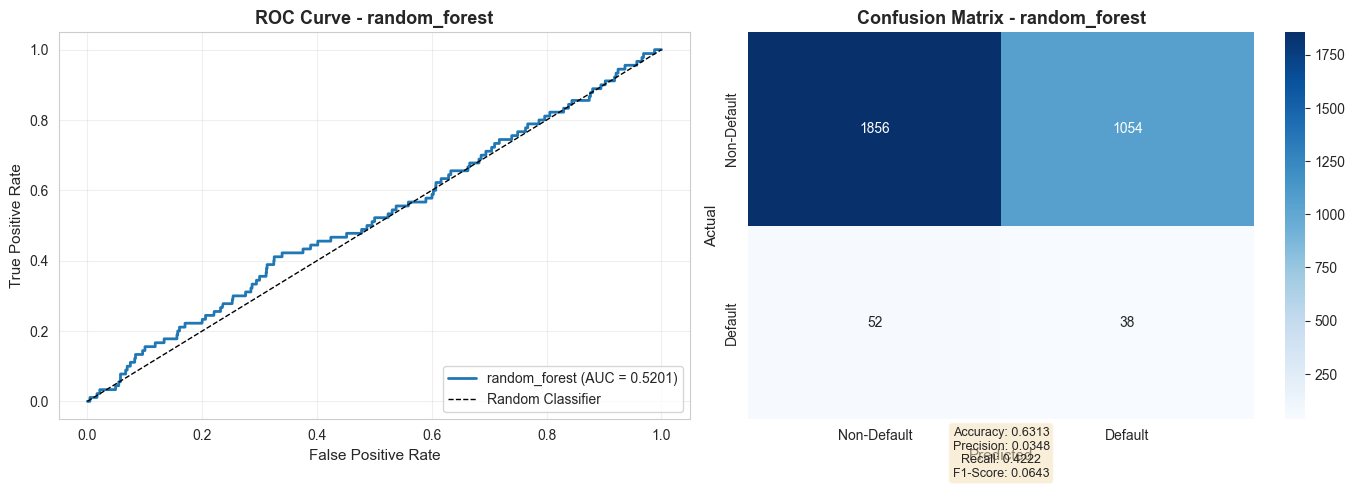


Visualizing Results for XGBOOST...

✓ Saved visualization to plots/xgboost_results.png


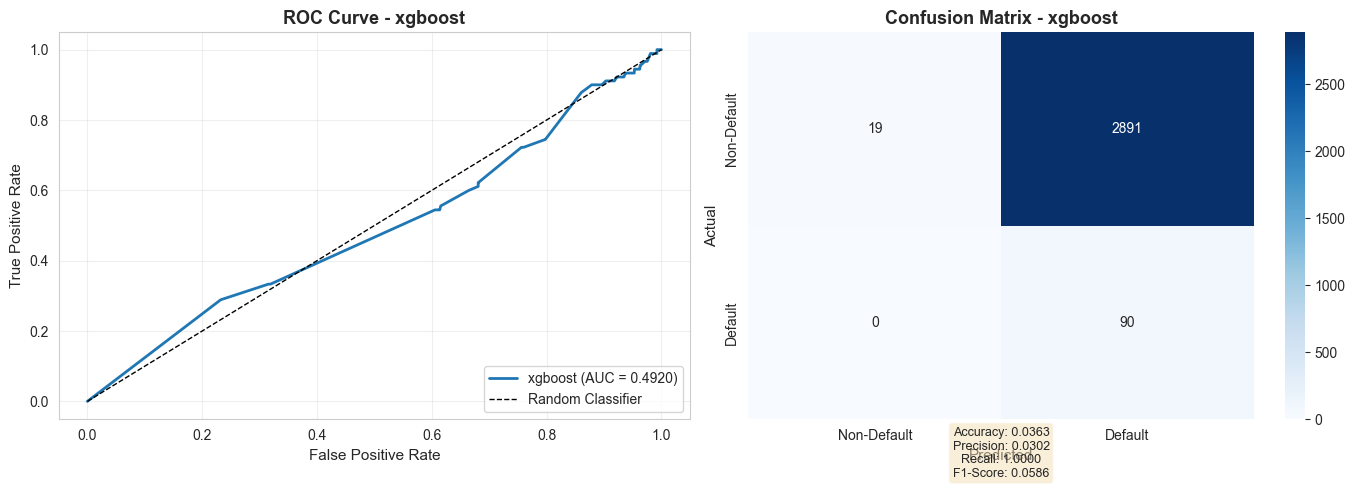

In [15]:
for model_name, model in trained_models.items():
    print(f"\n{'='*80}")
    print(f"Visualizing Results for {model_name.upper()}...")
    print(f"{'='*80}\n")
    
    train.visualize_model_results(
        model=model,
        X_test=X_test,
        y_test=y_test,
        model_name=model_name,
        save_path=config.OUTPUT_PATHS['plots']
    )


### 8.1 Model Comparison on Test Set


MODEL COMPARISON ON TEST SET
                         ROC-AUC      Gini  KS-Statistic  Accuracy  Precision    Recall  F1-Score
random_forest           0.520147  0.040294      0.085682  0.631333   0.034799  0.422222  0.064298
logistic_regression     0.513979  0.027957      0.080069  0.562000   0.032110  0.466667  0.060086
hist_gradient_boosting  0.501405  0.002810      0.048568  0.490667   0.030065  0.511111  0.056790
xgboost                 0.491984 -0.016033      0.056586  0.036333   0.030191  1.000000  0.058613
knn                     0.482071 -0.035857      0.031042  0.681333   0.028322  0.288889  0.051587


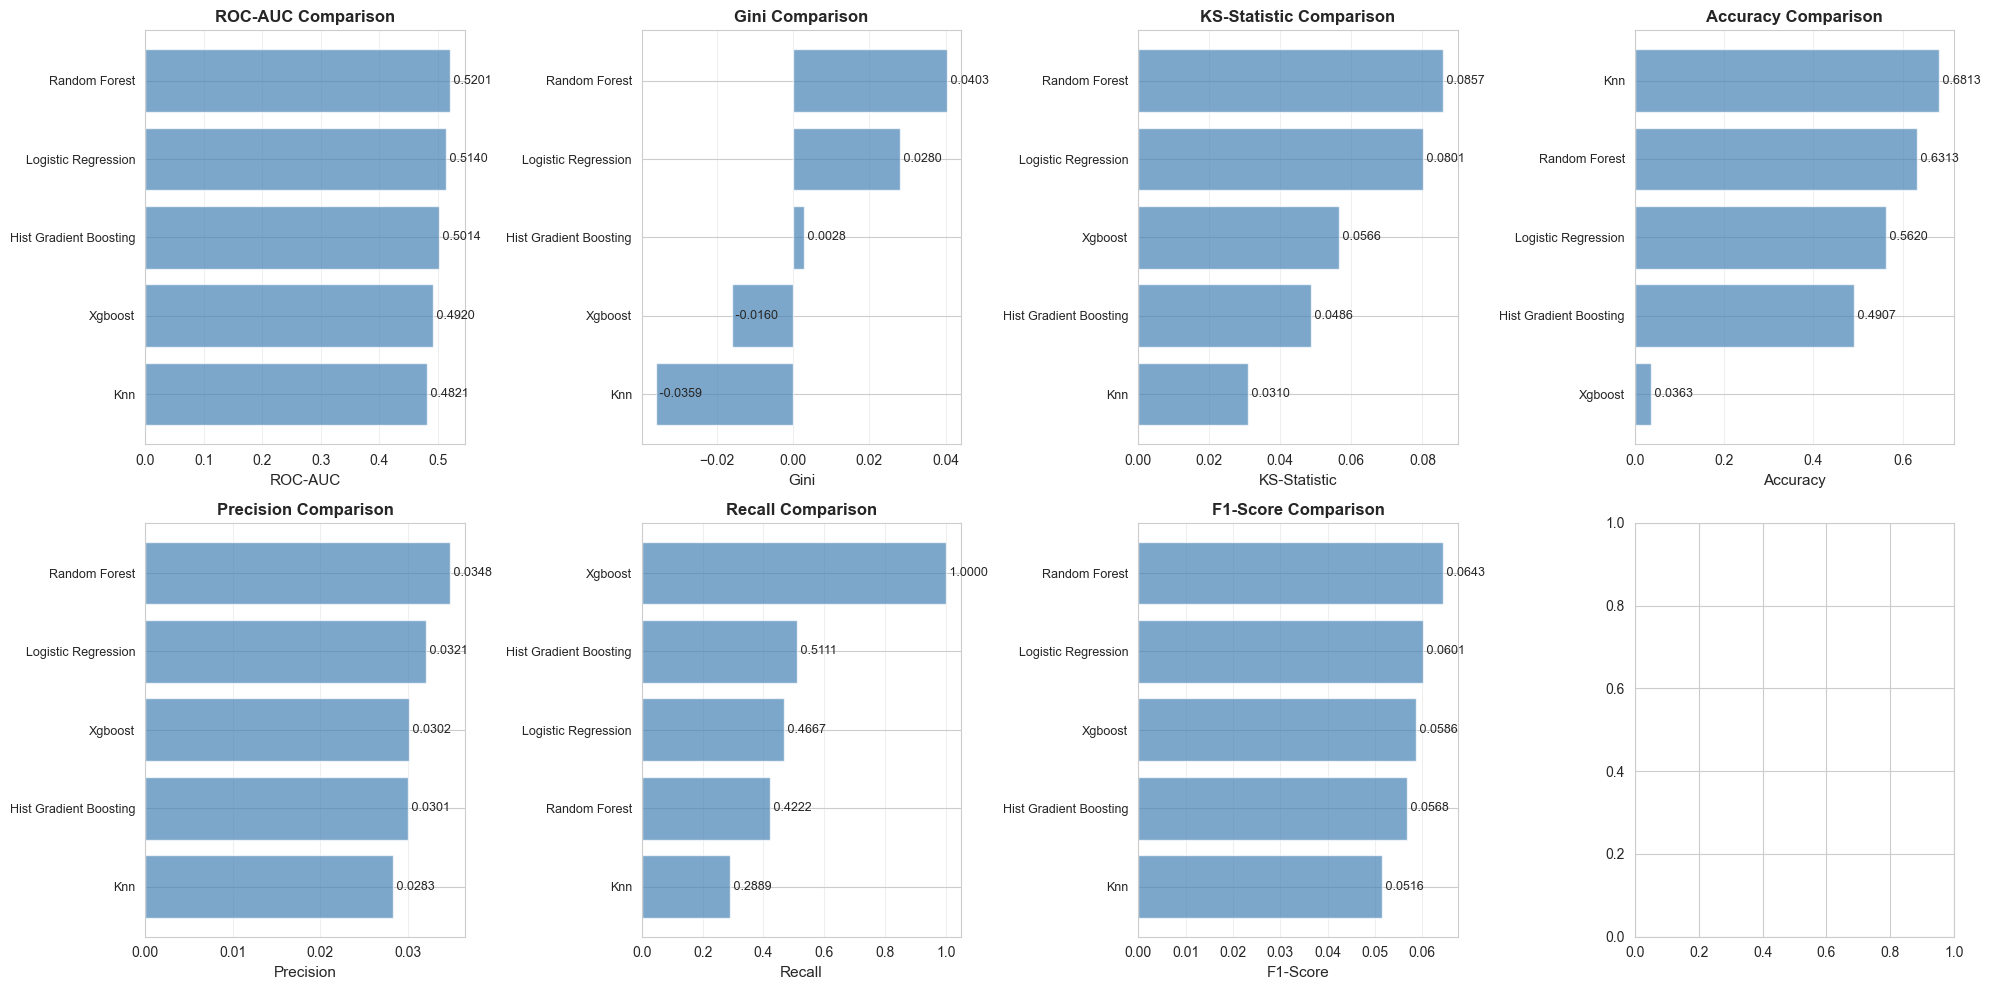

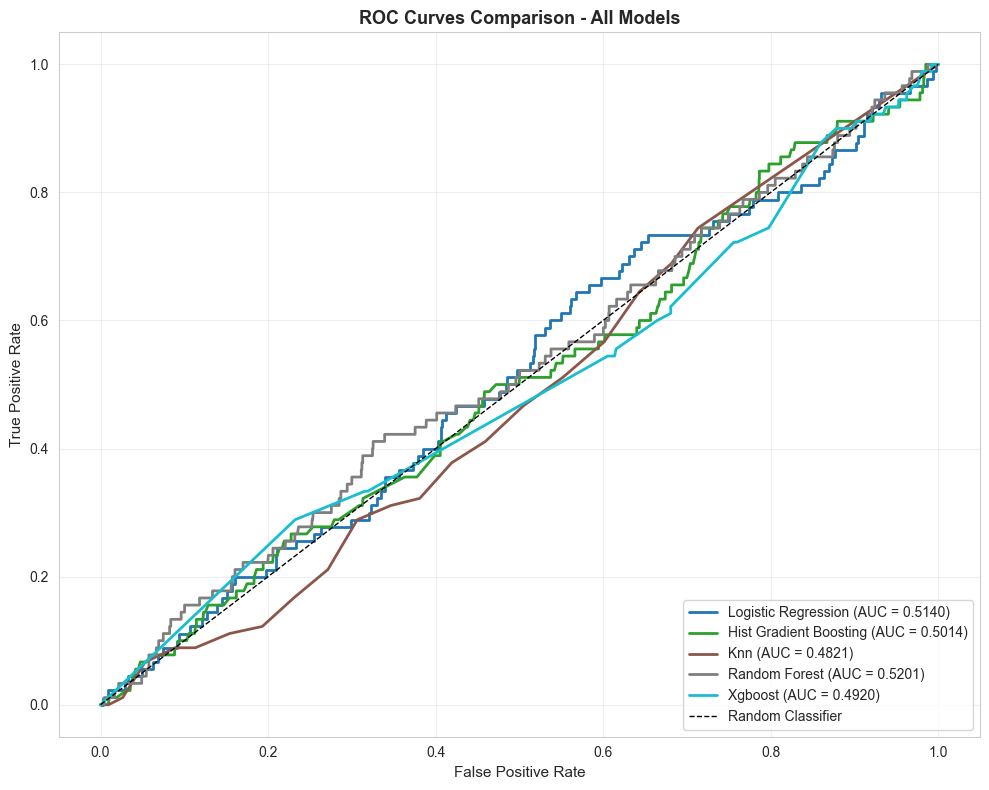


✓ Saved visualizations:
  - ROC curves comparison: plots/roc_curves_comparison.png
  - Metrics comparison: plots/metrics_comparison.png

BEST MODEL: RANDOM FOREST
ROC-AUC: 0.5201
Gini: 0.0403
KS-Statistic: 0.0857
Accuracy: 0.6313
Precision: 0.0348
Recall: 0.4222
F1-Score: 0.0643

SAVING MODEL RESULTS TO CSV
SAVING MODEL RESULTS TO CSV
✓ Saved test set results to: reports/model_test_results.csv
✓ Saved cross-validation results to: reports/model_cv_results.csv
✓ Saved model comparison summary to: reports/model_comparison_summary.csv


In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

test_results = {}
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * (roc_auc - 0.5)
    ks_statistic = np.max(tpr - fpr)
    
    test_results[model_name] = {
        'roc_auc': roc_auc,
        'gini': gini,
        'ks_statistic': ks_statistic,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

comparison_df = pd.DataFrame(test_results).T
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)
comparison_df.columns = ['ROC-AUC', 'Gini', 'KS-Statistic', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

print("=" * 80)
print("MODEL COMPARISON ON TEST SET")
print("=" * 80)
print(comparison_df.to_string())

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

metrics = ['roc_auc', 'gini', 'ks_statistic', 'accuracy', 'precision', 'recall', 'f1_score']
metric_names = ['ROC-AUC', 'Gini', 'KS-Statistic', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]
    sorted_models = comparison_df.sort_values(metric_name, ascending=True)
    bars = ax.barh(range(len(sorted_models)), sorted_models[metric_name].values, color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(sorted_models)))
    ax.set_yticklabels([m.replace('_', ' ').title() for m in sorted_models.index], fontsize=9)
    ax.set_xlabel(metric_name, fontsize=11)
    ax.set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    
    for i, v in enumerate(sorted_models[metric_name].values):
        ax.text(v, i, f' {v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATHS['plots'], 'metrics_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(trained_models)))
for idx, (model_name, model) in enumerate(trained_models.items()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name.replace("_", " ").title()} (AUC = {roc_auc:.4f})', 
             linewidth=2, color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves Comparison - All Models', fontsize=13, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATHS['plots'], 'roc_curves_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved visualizations:")
print(f"  - ROC curves comparison: {os.path.join(config.OUTPUT_PATHS['plots'], 'roc_curves_comparison.png')}")
print(f"  - Metrics comparison: {os.path.join(config.OUTPUT_PATHS['plots'], 'metrics_comparison.png')}")

best_model_name = comparison_df.index[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name.upper().replace('_', ' ')}")
print(f"{'='*80}")
print(f"ROC-AUC: {comparison_df.loc[best_model_name, 'ROC-AUC']:.4f}")
print(f"Gini: {comparison_df.loc[best_model_name, 'Gini']:.4f}")
print(f"KS-Statistic: {comparison_df.loc[best_model_name, 'KS-Statistic']:.4f}")
print(f"Accuracy: {comparison_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"Precision: {comparison_df.loc[best_model_name, 'Precision']:.4f}")
print(f"Recall: {comparison_df.loc[best_model_name, 'Recall']:.4f}")
print(f"F1-Score: {comparison_df.loc[best_model_name, 'F1-Score']:.4f}")

print(f"\n{'='*80}")
print("SAVING MODEL RESULTS TO CSV")
print(f"{'='*80}")

try:
    cv_results_for_csv = cv_results_all
except NameError:
    cv_results_for_csv = None

train.save_model_results_to_csv(
    test_results=test_results,
    cv_results_all=cv_results_for_csv,
    config_module=config,
    output_dir=config.OUTPUT_PATHS['reports']
)


### Key Findings:


- Data preprocessing and preparation completed for model training
- Missing values imputed using appropriate techniques
- Data types standardized and optimized
- Feature engineering performed using feature_engineering_test.py module
- Correlation analysis conducted; no significant multicollinearity detected
- Machine learning algorithms selected and implemented
- Results visualized with comprehensive plots
- Model performance metrics evaluated (ROC-AUC, Gini Coefficient, KS Statistic, Accuracy, Precision, Recall, F1-Score)
- Feature importance analysis performed to identify key drivers of default prediction across different model architectures
- Comparative model evaluation and selection recommendations provided based on performance metrics
- Detailed results exported to CSV files for further analysis and documentation